In [200]:
import itertools as it
import copy
import os.path as op
import pickle
import matplotlib.pylab as plt
from matplotlib import colors
from mne import read_epochs, viz
from extra.tools import many_is_in
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_test, permutation_cluster_test, ttest_1samp_no_p

In [2]:
scaler_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/scaler_MEG.pkl"
PCA_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_solution_MEG.pkl"
dataset = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/sub_metrics.pkl"
visual_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-visual-epo.fif"
motor_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-motor-epo.fif"
burst_features_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features_sensors.csv"
burst_features_file_old = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features.csv"

waveform_array_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/all_waveforms.npy"

In [173]:
visual_epochs = read_epochs(visual_epoch_file, verbose=False)
visual_epochs.pick_types(meg=True, ref_meg=False, misc=False)
visual_times = visual_epochs.times
visual_info = visual_epochs.info
motor_epochs = read_epochs(motor_epoch_file, verbose=False)
motor_epochs.pick_types(meg=True, ref_meg=False, misc=False)
motor_times = motor_epochs.times
motor_info = motor_epochs.info
sens = ["MLC1", "MLC25", "MLC32", "MLC42", "MLC54", "MLC55", "MLC63"]
channels_used = [i for i in visual_info.ch_names if many_is_in(["MLC"], i)]
channels_used = [i for i in channels_used if not many_is_in(sens, i)]
channel_map = np.array([many_is_in(channels_used, i) for i in visual_info.ch_names]).astype(bool)

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


In [3]:
if op.exists(burst_features_file):
    output_dict = pd.read_csv(burst_features_file)
else:
    sub_metrics = pickle.load(open(dataset, "rb"))
    scaler_meg = pickle.load(open(scaler_path, "rb"))
    PCA_saved = pickle.load(open(PCA_path, "rb"))
    features_columns = [
        "peak_time", "peak_freq", "peak_amp_base", 
        "fwhm_freq", "fwhm_time", "trial", "pp_ix", "block", 
        "sensor", "trial_type", "subject"
    ]
    PC_columns = ["PC_" + str(i+1) for i in range(20)]

    columns = features_columns + PC_columns

    output_dict = {i: [] for i in columns}

    for sub in sub_metrics.keys():
        for cat in ["vis", "mot"]:
            for ft in features_columns:
                shape = len(sub_metrics[sub][cat]["peak_time"])
                if ft == "trial_type":
                    output_dict["trial_type"].append([cat] * shape)
                elif ft == "subject":
                    output_dict["subject"].append([sub] * shape)
                else:
                    output_dict[ft].append(sub_metrics[sub][cat][ft])
            PCS = PCA_saved.transform(scaler_meg.transform(sub_metrics[sub][cat]["waveform"]))
            for PC_ix, PC_lab in enumerate(PC_columns):
                output_dict[PC_lab].append(PCS[:,PC_ix])
    output_dict = {i: np.hstack(output_dict[i]).flatten() for i in columns}
    output_dict = pd.DataFrame.from_dict(output_dict)
    output_dict.to_csv(burst_features_file, index=False)

In [117]:
pcs = ["PC_7", "PC_8", "PC_9", "PC_10"]

times = {
    "baseline": ("vis", -0.5, -0.25),
    "onset_vis": ("vis", -0.125, 0.125),
    "mid_vis": ("vis", 0.75, 1.0),
    "pre_mot": ("mot", -0.625, -0.375),
    "peri_offset": ("mot", -0.125, 0.125),
    "rebound": ("mot", 0.5, 0.75)
}

prct = np.linspace(0,100, num=5)
prct[0] = 1
prct[-1] = 99
# prct_range = {ix: np.percentile(output_dict.PC_7, i) for ix, i in enumerate(prct)}
prct_ranges = list(zip(np.arange(5)[:-1], np.arange(5)[1:]))

In [118]:
columns = ["subject", "sensor", "peak_time", "pp_ix", "trial_type"] + pcs
output_dict = output_dict[columns]

pc_ranges_columns = []

for pc in pcs:
    column_name = pc + "_range"
    pc_ranges_columns.append(column_name)
    output_dict[column_name] = None
    prct_range = {ix: np.percentile(output_dict[pc], i) for ix, i in enumerate(prct)}
    for pr_ix, (l_b, u_b) in enumerate(prct_ranges):
        output_dict[column_name][
            (output_dict[pc] >= prct_range[l_b]) & (output_dict[pc] < prct_range[u_b])
        ] = pr_ix
output_dict.dropna(axis=0, how="any", inplace=True)
print(output_dict.columns)

Index(['subject', 'sensor', 'peak_time', 'pp_ix', 'trial_type', 'PC_7', 'PC_8',
       'PC_9', 'PC_10', 'PC_7_range', 'PC_8_range', 'PC_9_range',
       'PC_10_range'],
      dtype='object')


In [119]:
output_dict["time_label"] = "outside"
for label in times.keys():
    start = times[label][1]
    stop = times[label][2]
    tt_ = times[label][0]
    output_dict["time_label"][
        (output_dict.peak_time >= start) & 
        (output_dict.peak_time < stop) & 
        (output_dict.trial_type == tt_)
    ] = label

In [155]:
select_output = output_dict.loc[output_dict.time_label != "outside"]

In [167]:
PRC_RES = {}
for pcr in pc_ranges_columns:
    sub_group = select_output.groupby(["subject", "sensor", "pp_ix", "time_label", pcr]).peak_time.count().unstack(fill_value=0).stack()
    sub_group = sub_group.reset_index()
    cols = sub_group.columns.tolist()
    cols[-1] = "burst_count"
    cols[-2] = "PC_range"
    sub_group.columns = cols
    sub_group.burst_count = sub_group.burst_count/0.25
    sub_group = sub_group.groupby(["subject", "sensor", "time_label", "PC_range"]).burst_count.mean().reset_index()
    
    for i in times.keys():
        sub_sub = sub_group.loc[sub_group.time_label == i].reset_index(drop=True)
        sub_sub = sub_sub.groupby(["sensor", "time_label", "PC_range"]).burst_count.mean()
        sub_sub = ((sub_sub - sub_sub.mean()) / sub_sub.mean()) * 100
        
        PRC_RES[(pcr, i)] = sub_sub.reset_index()

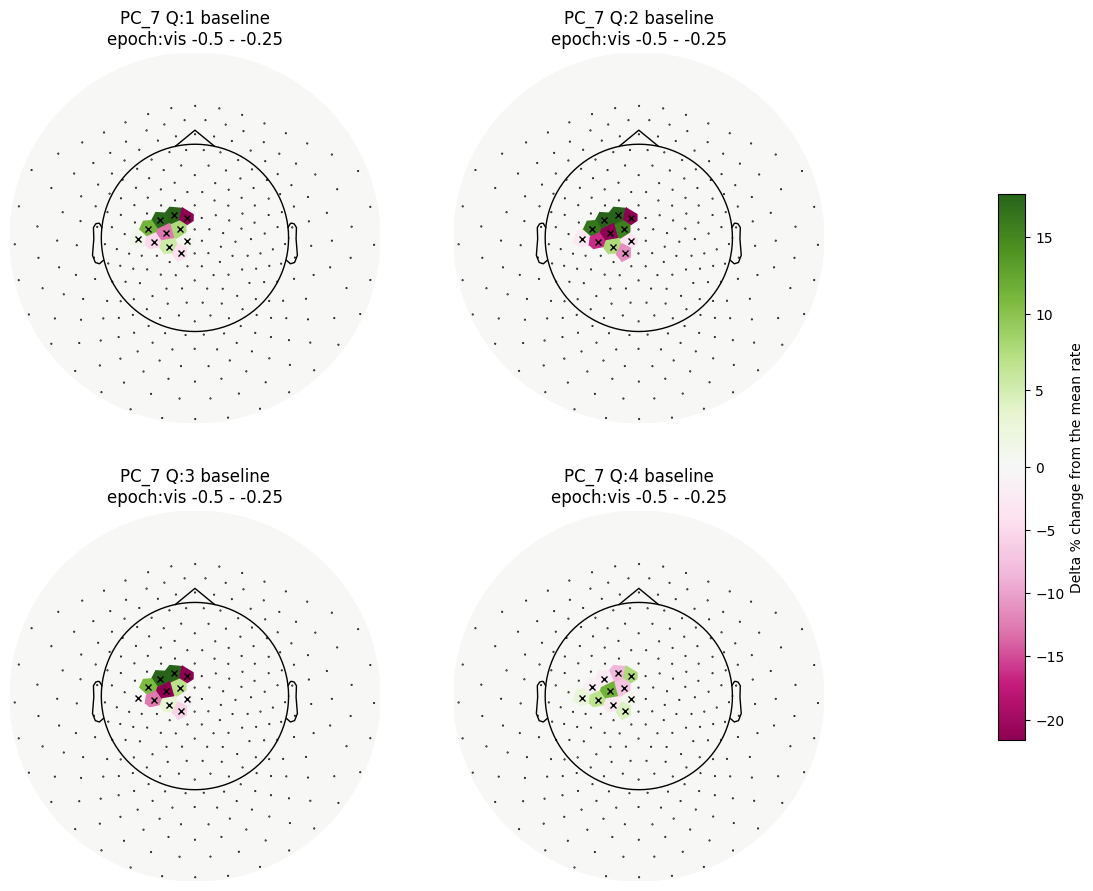

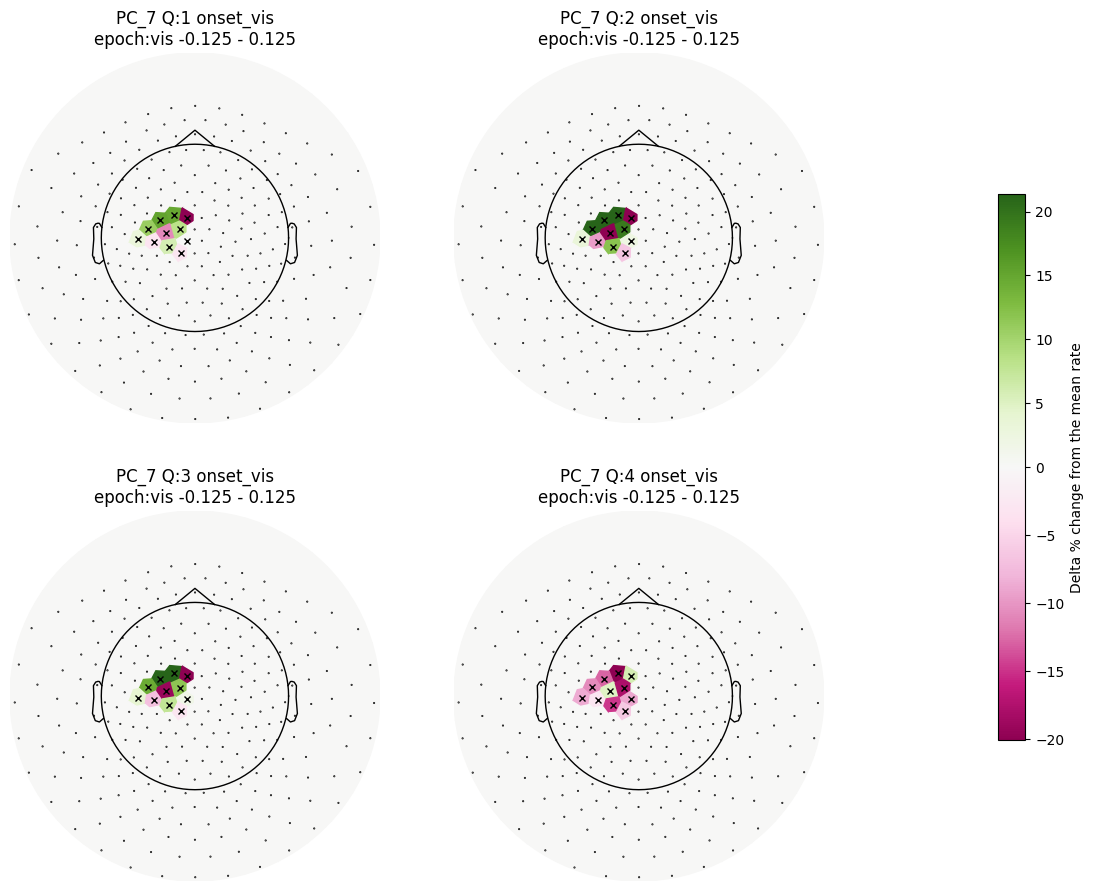

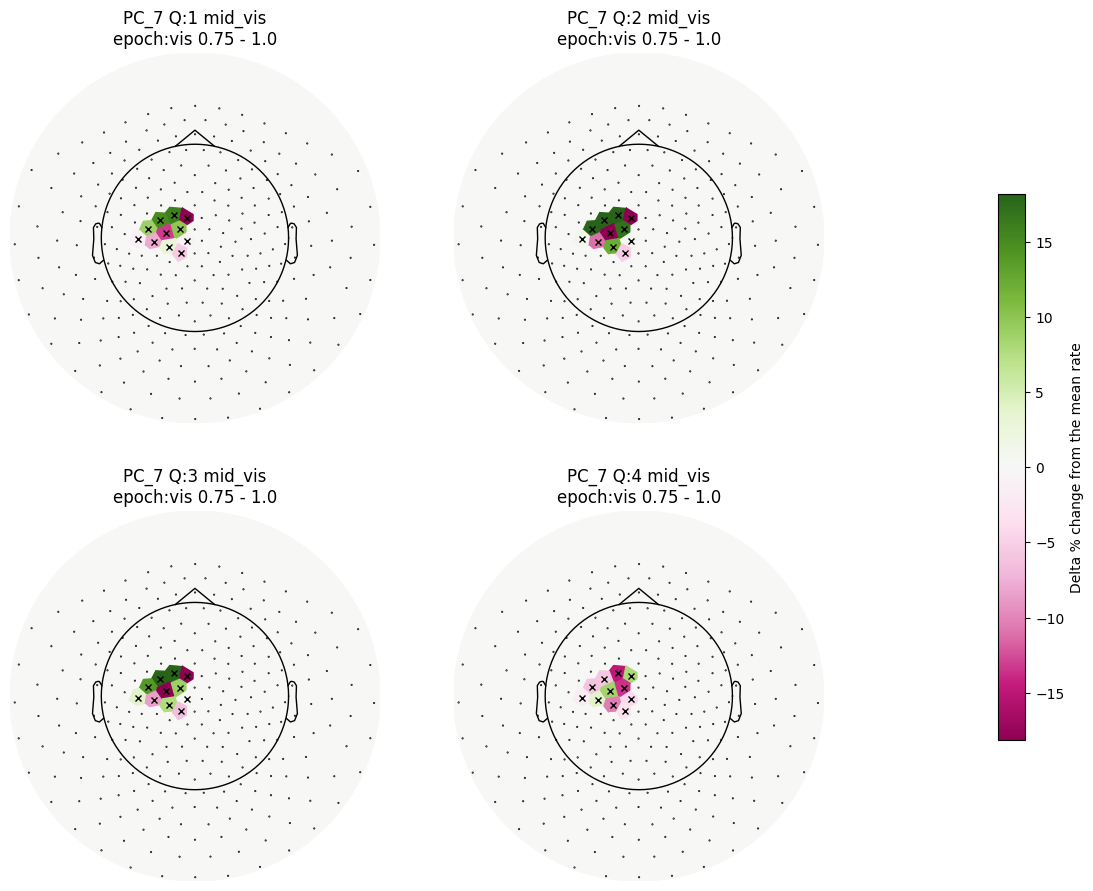

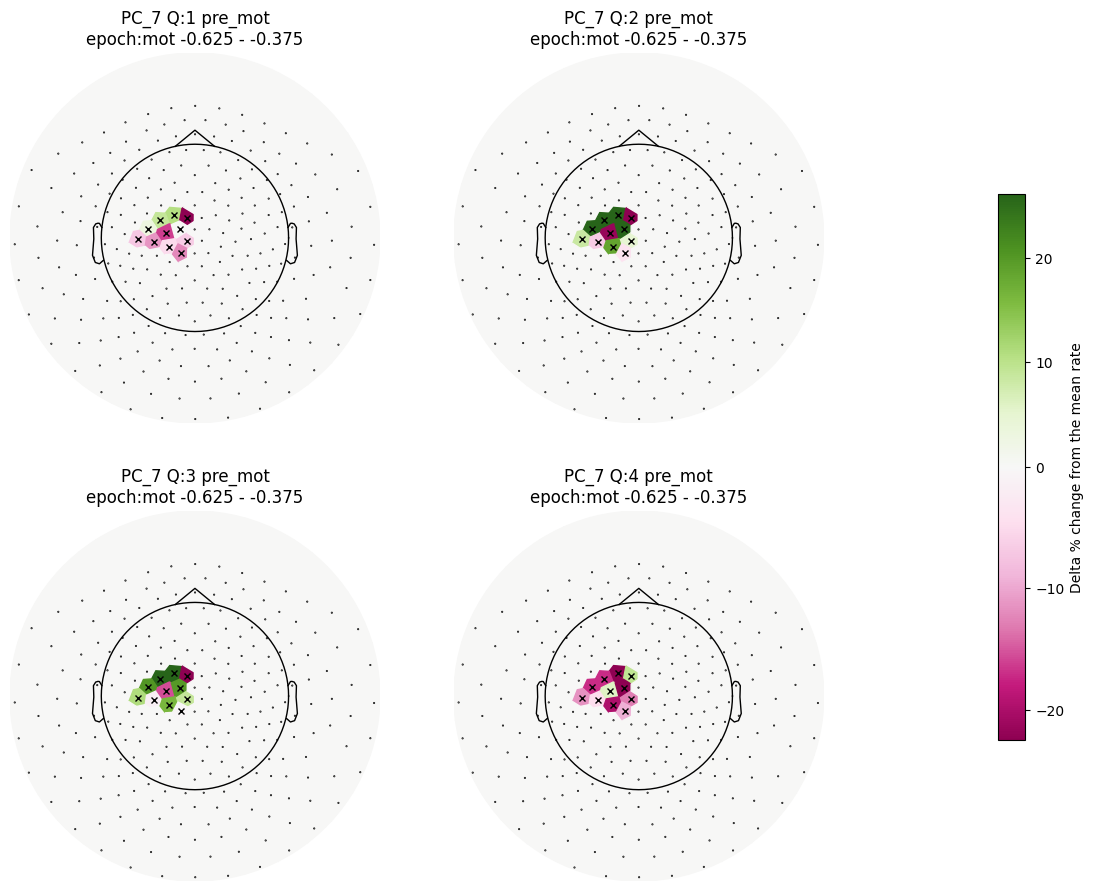

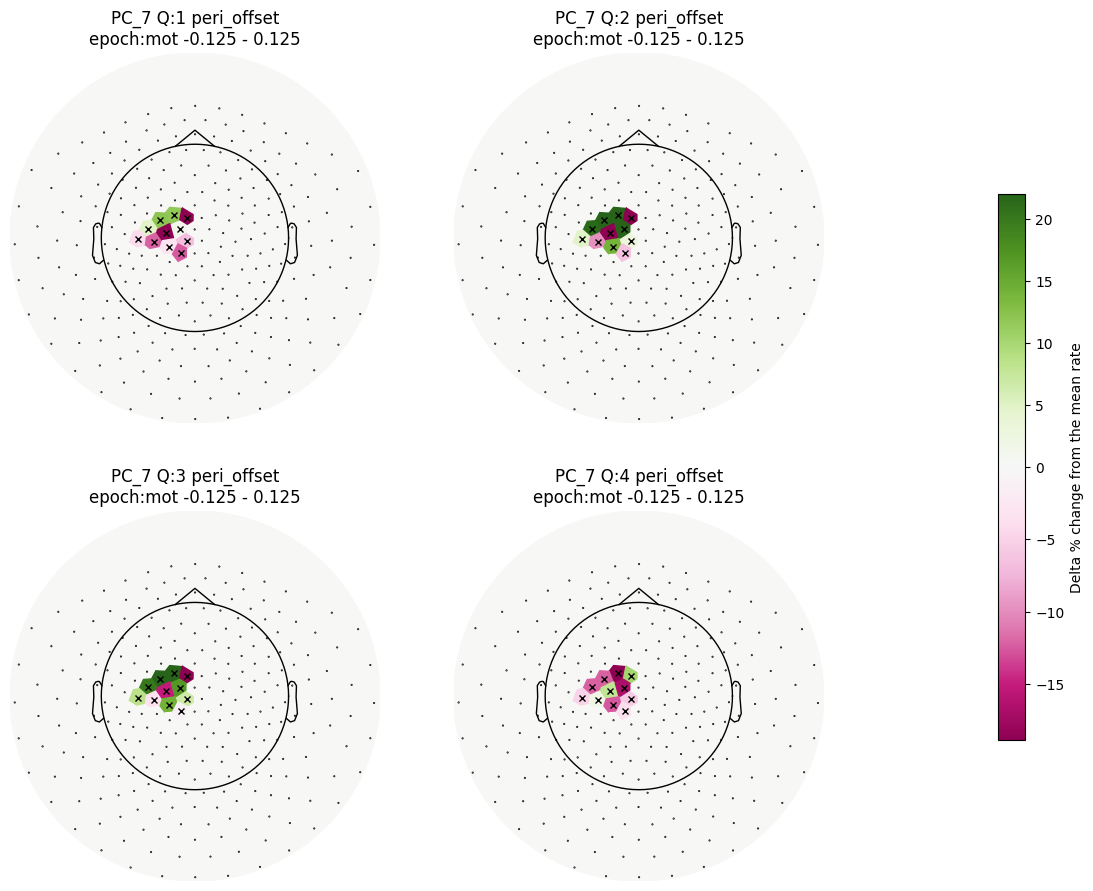

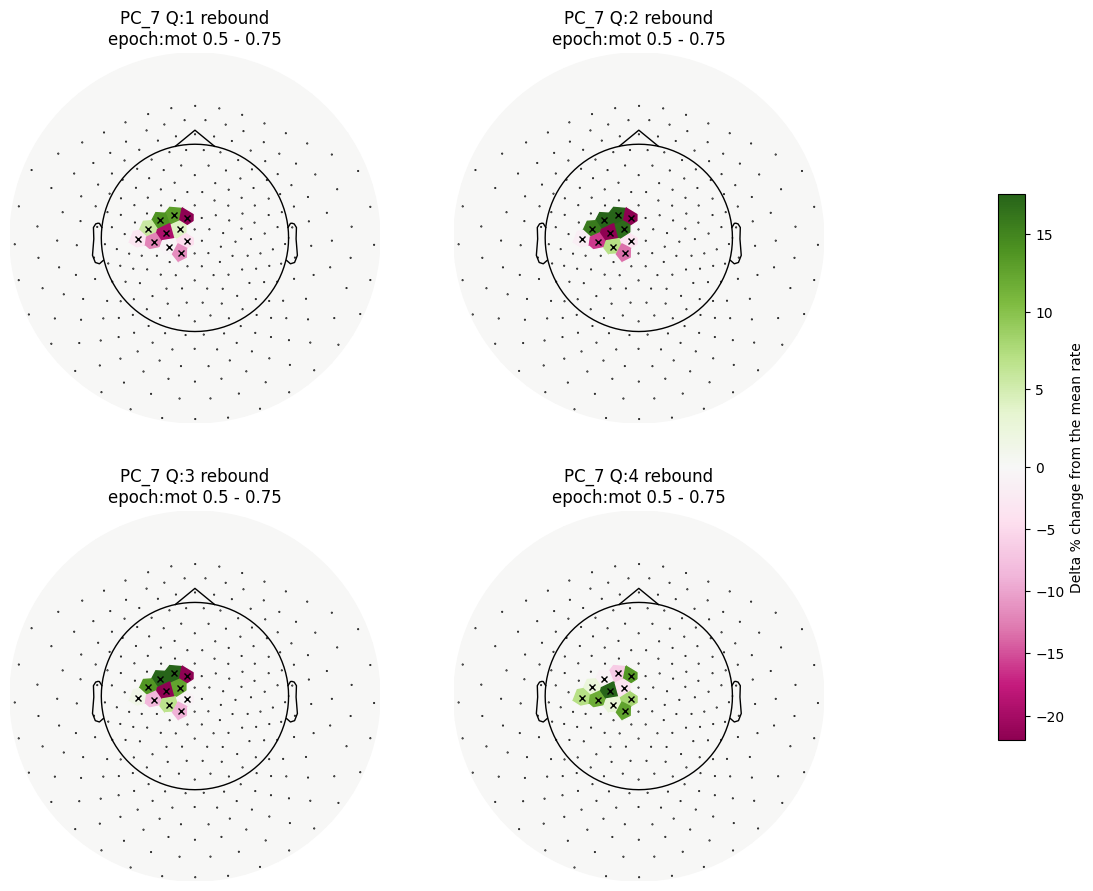

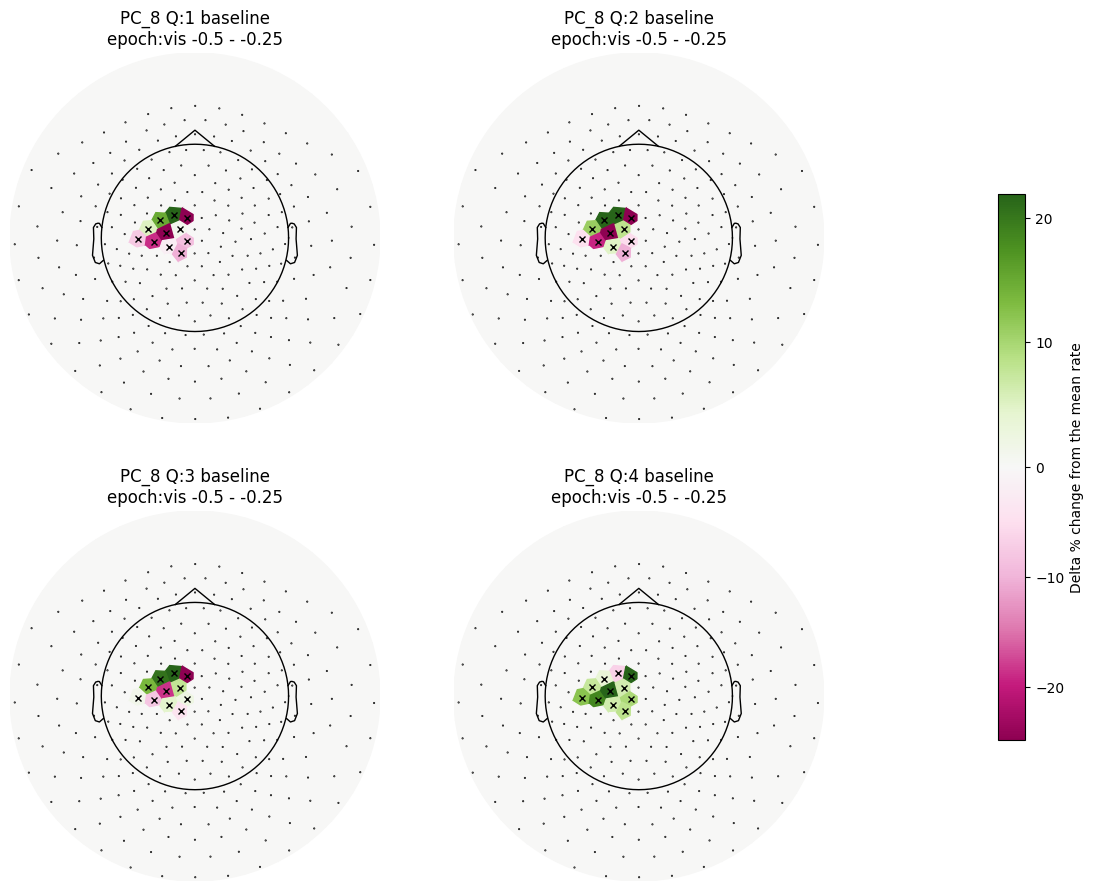

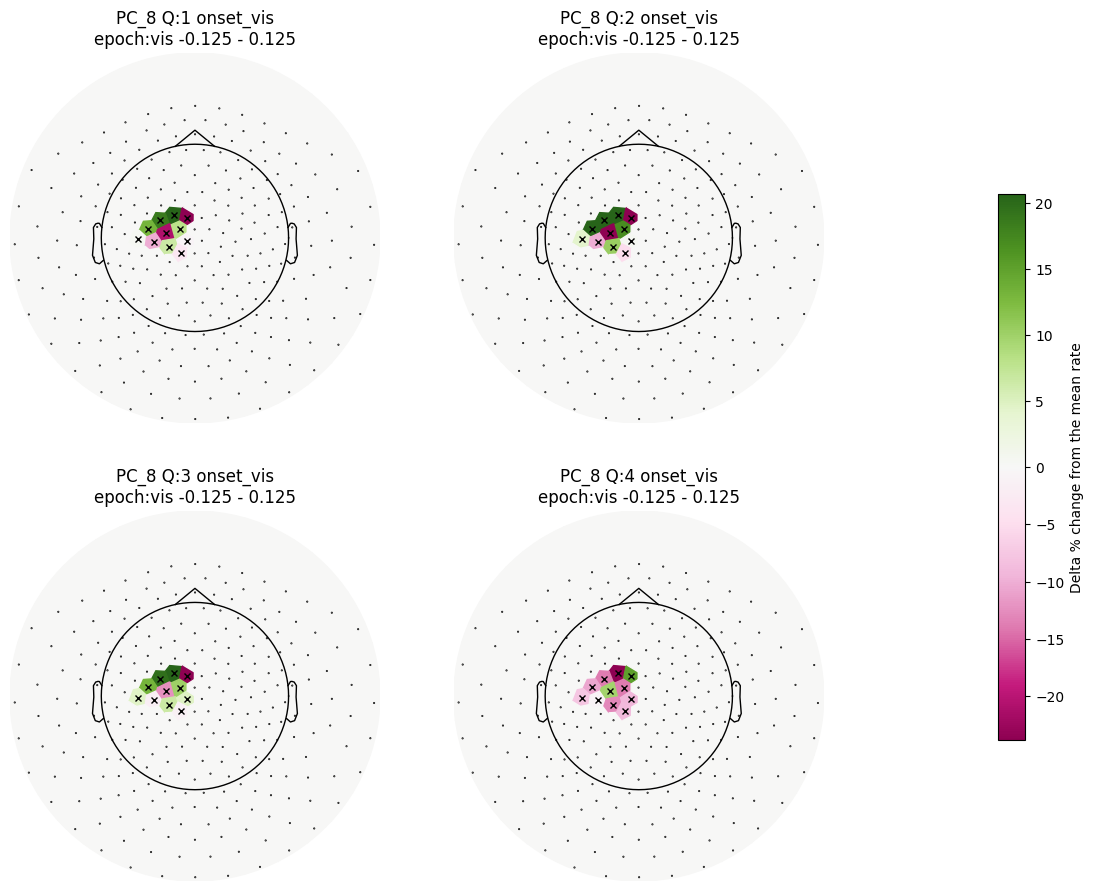

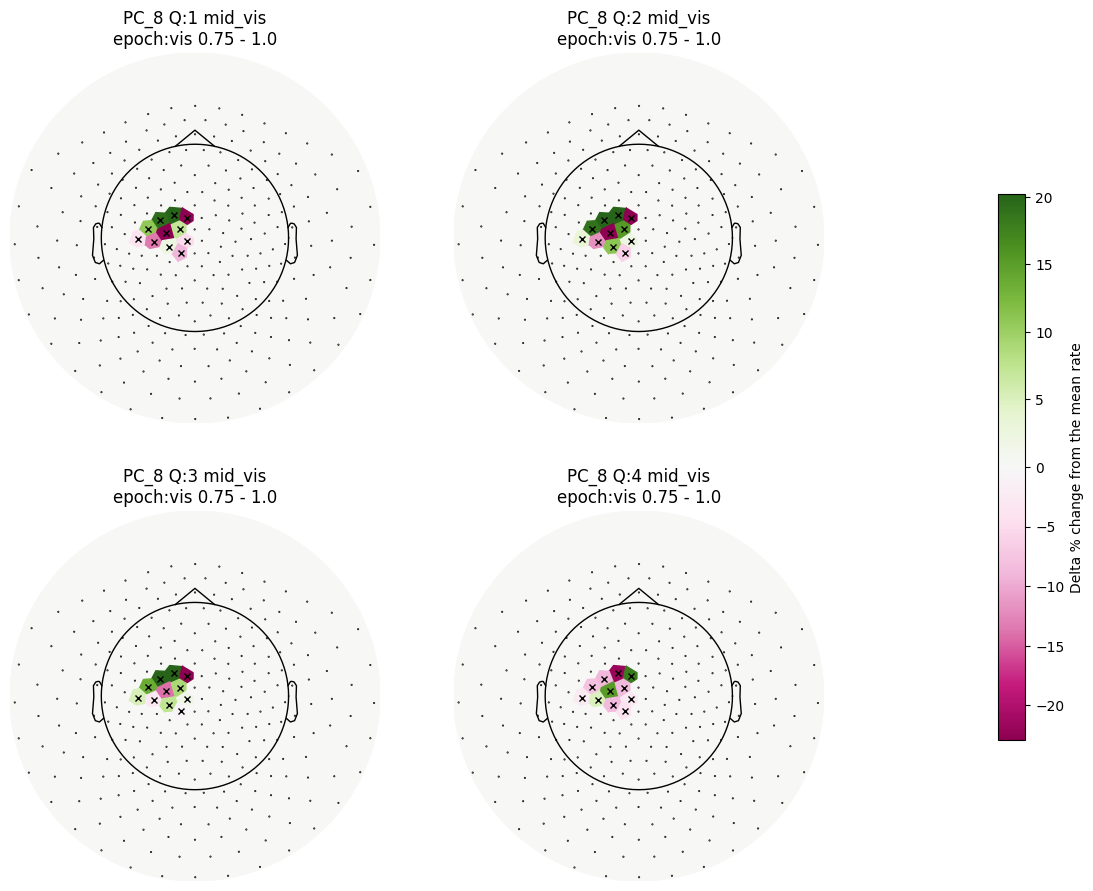

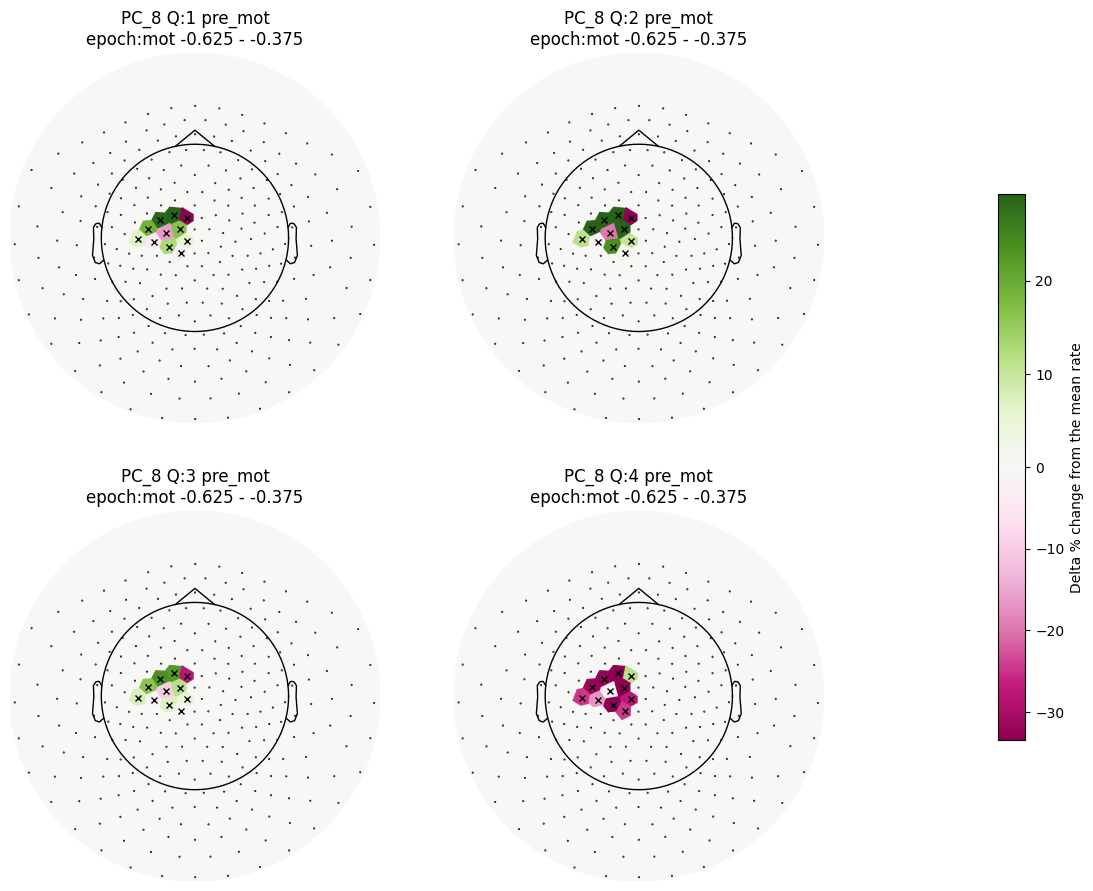

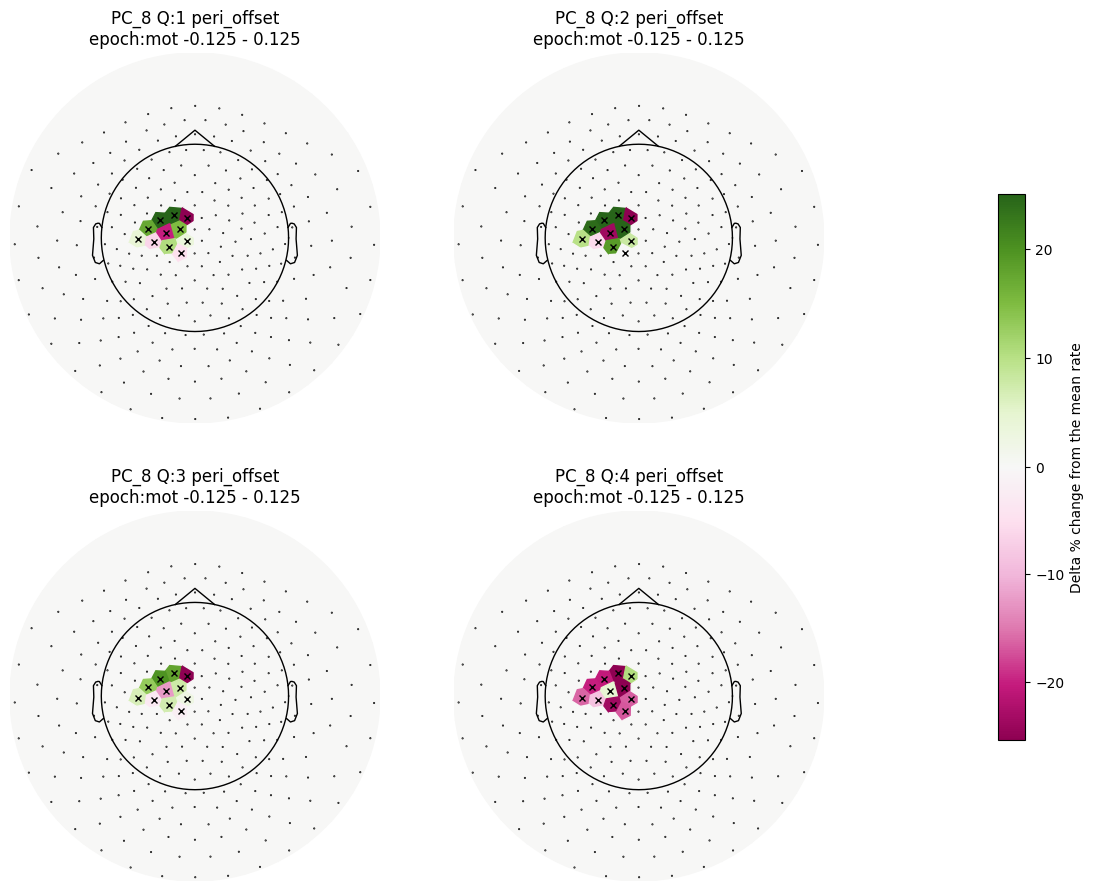

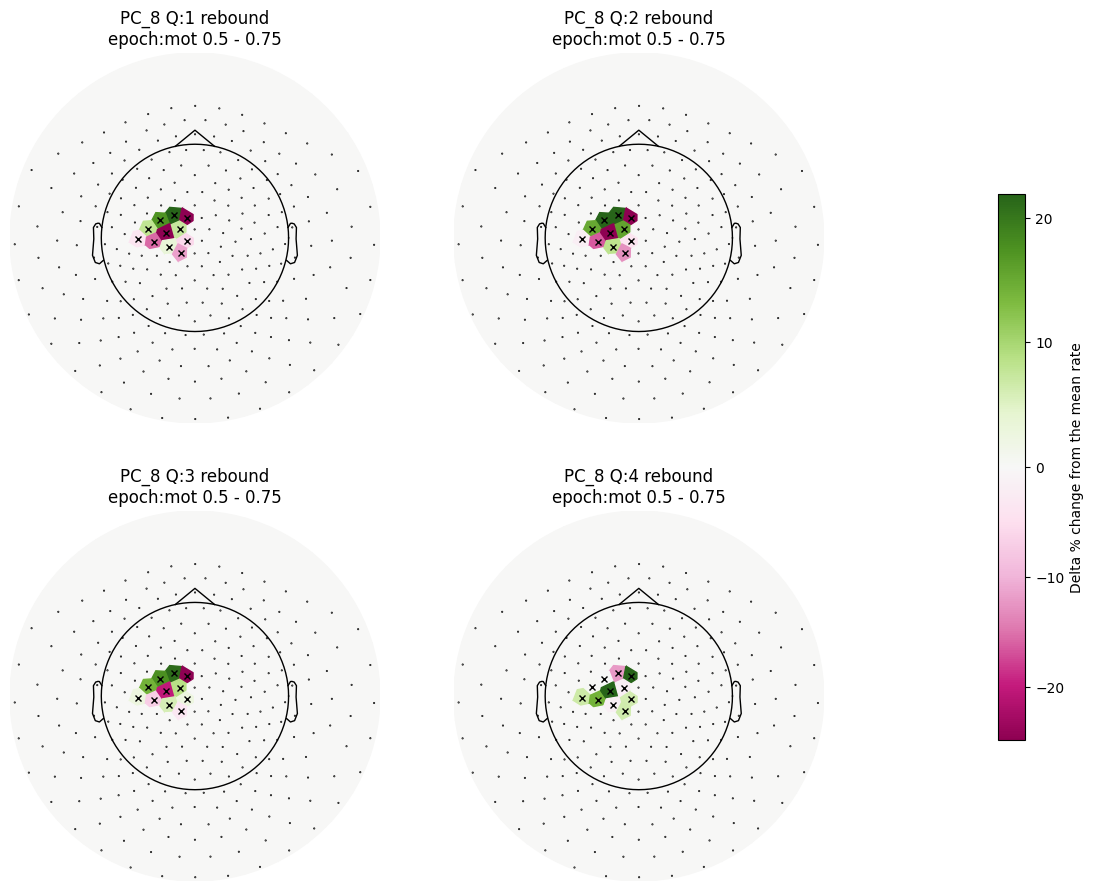

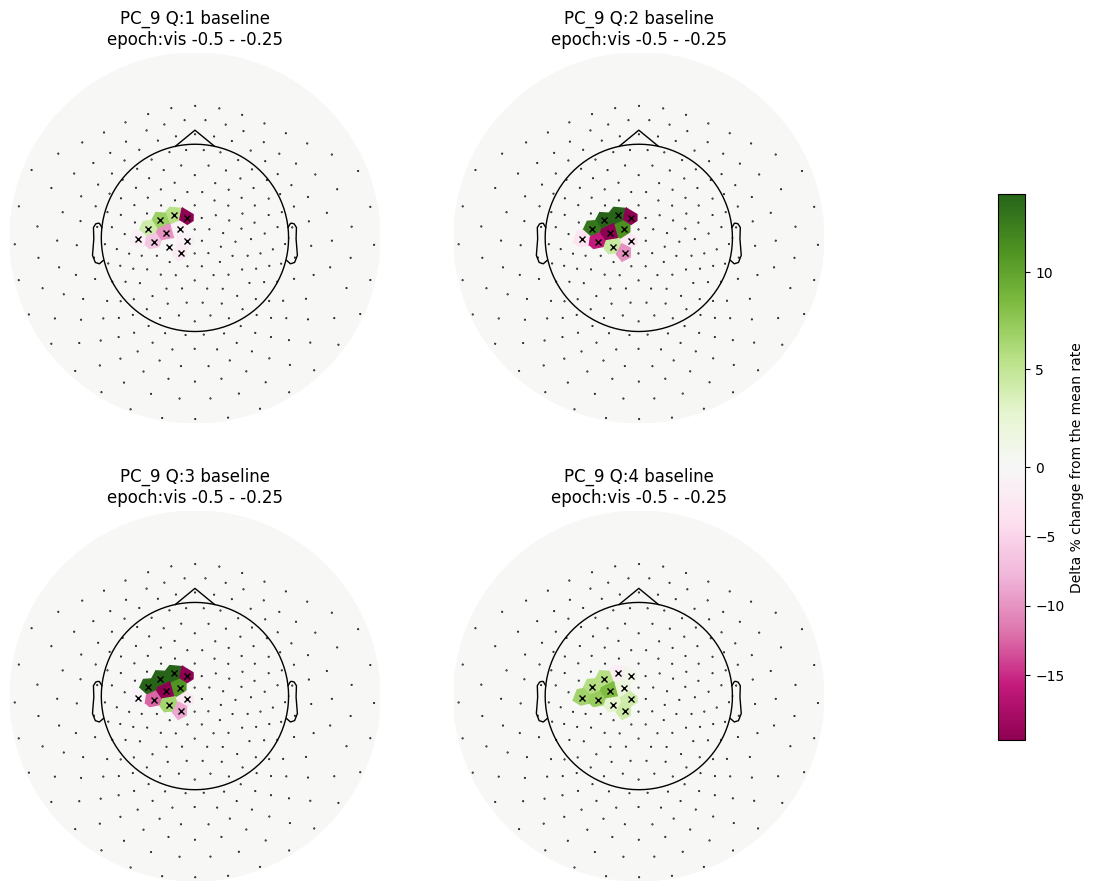

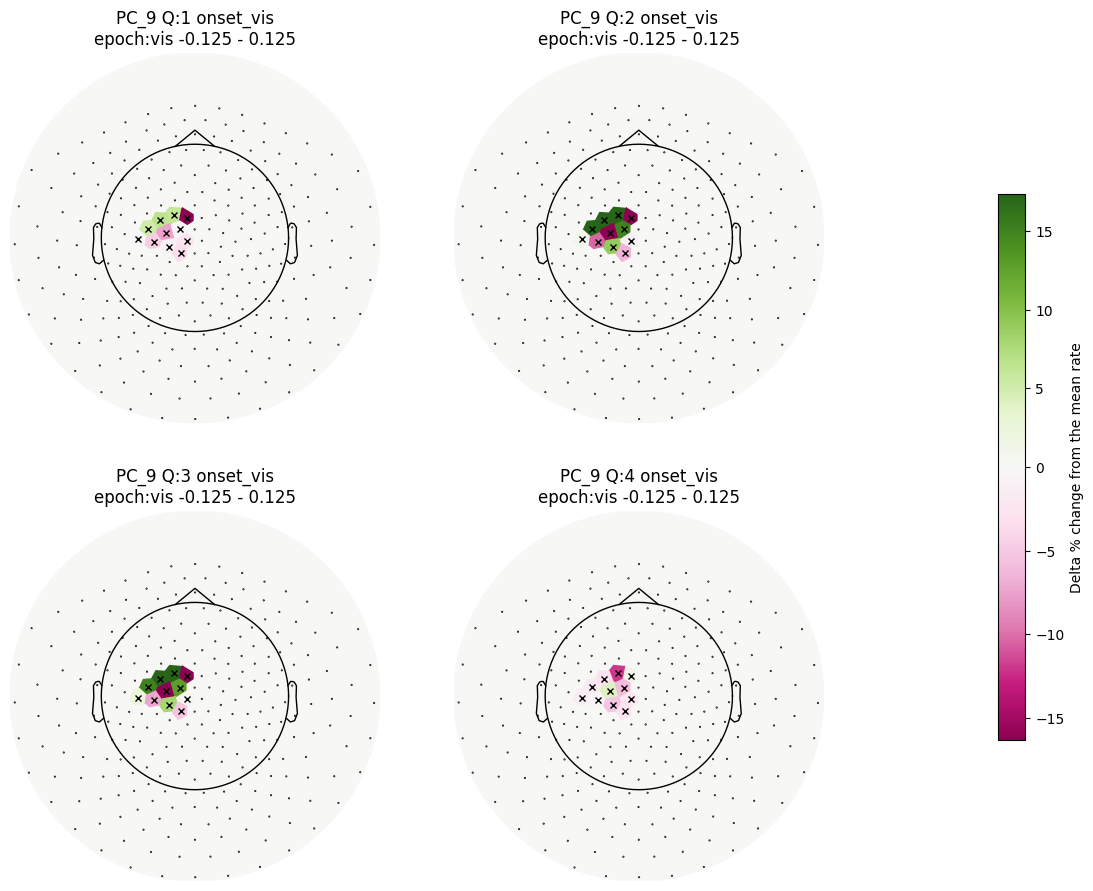

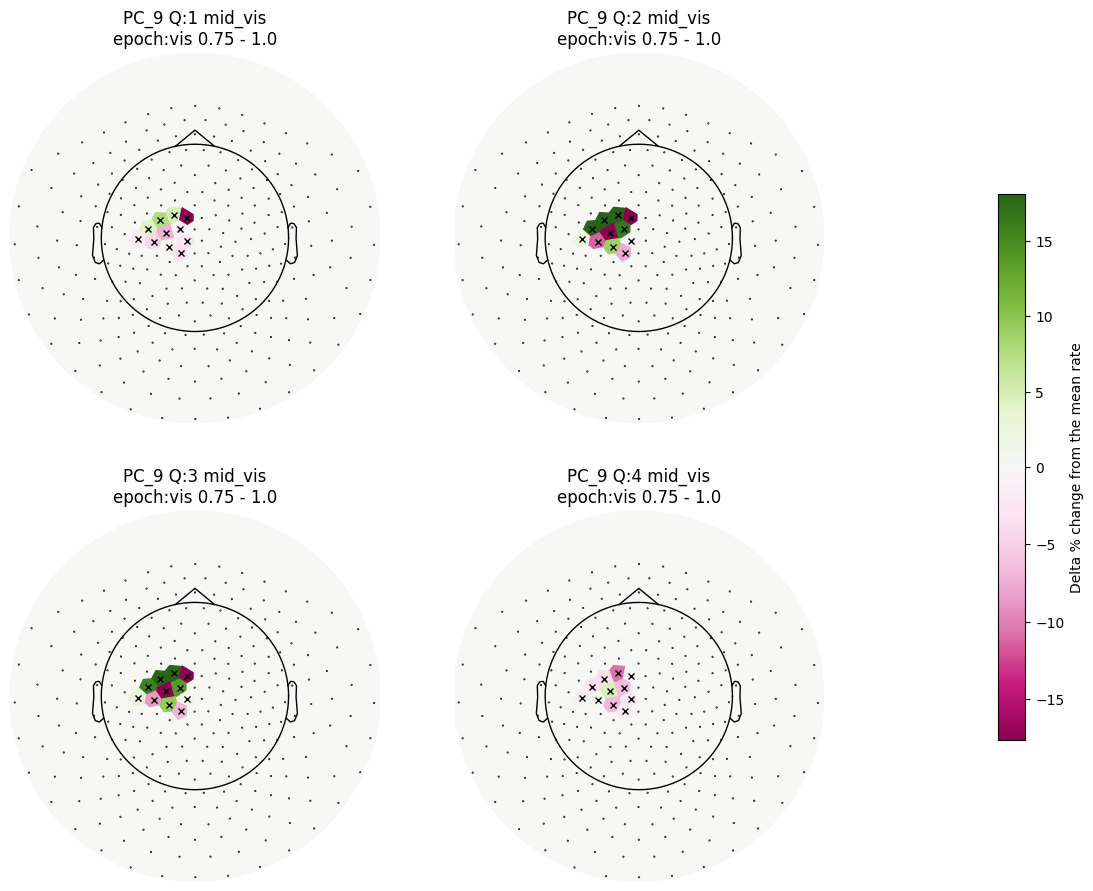

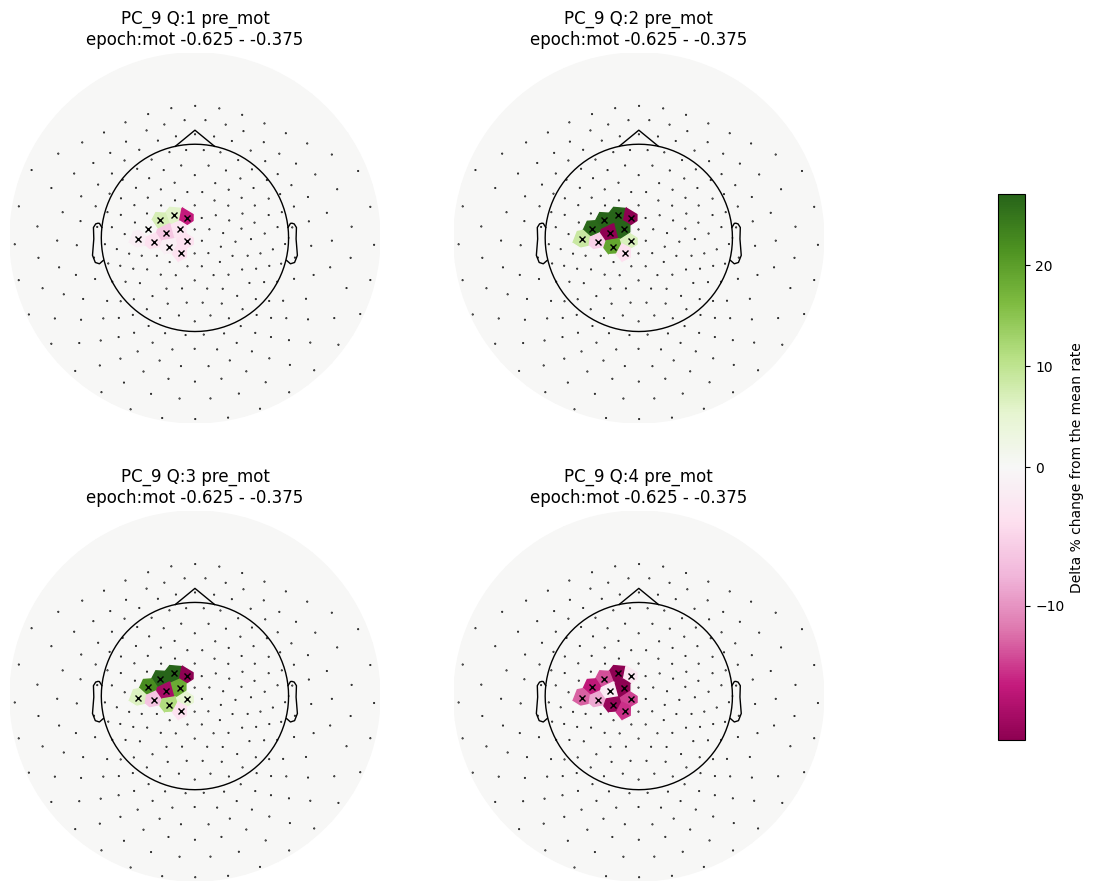

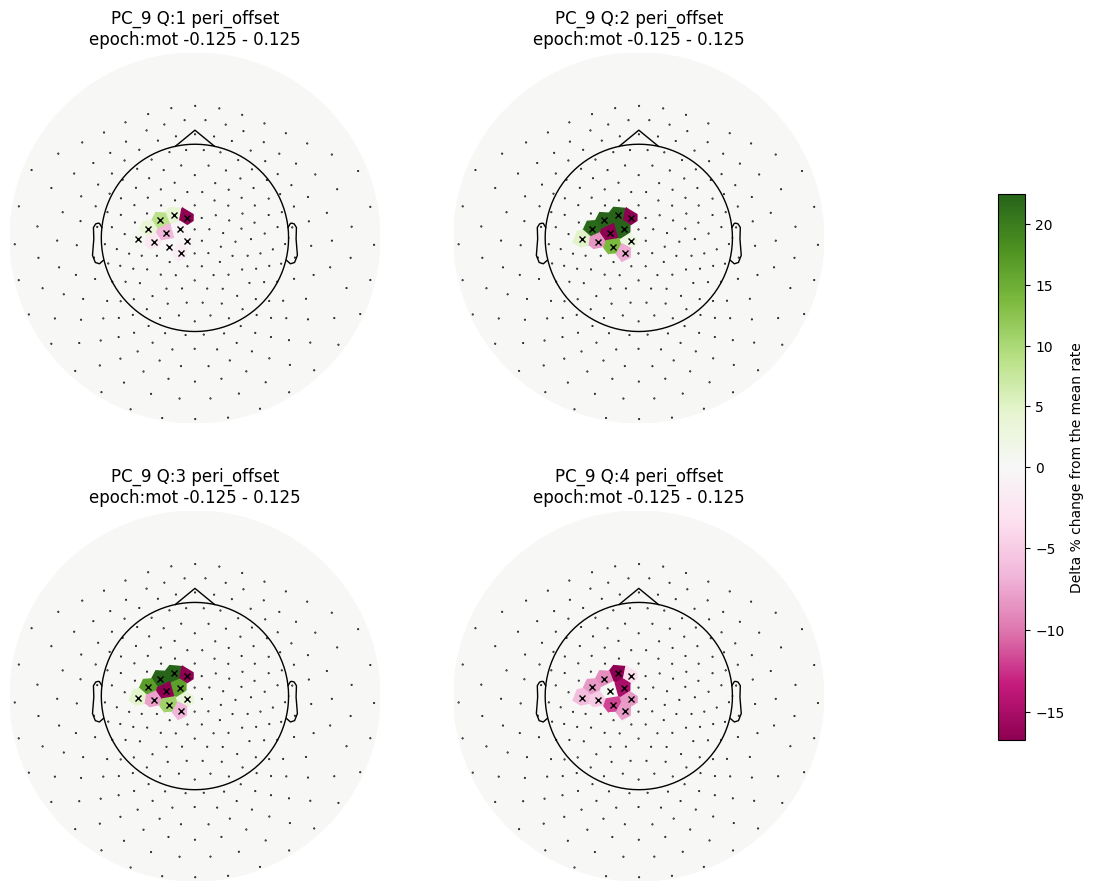

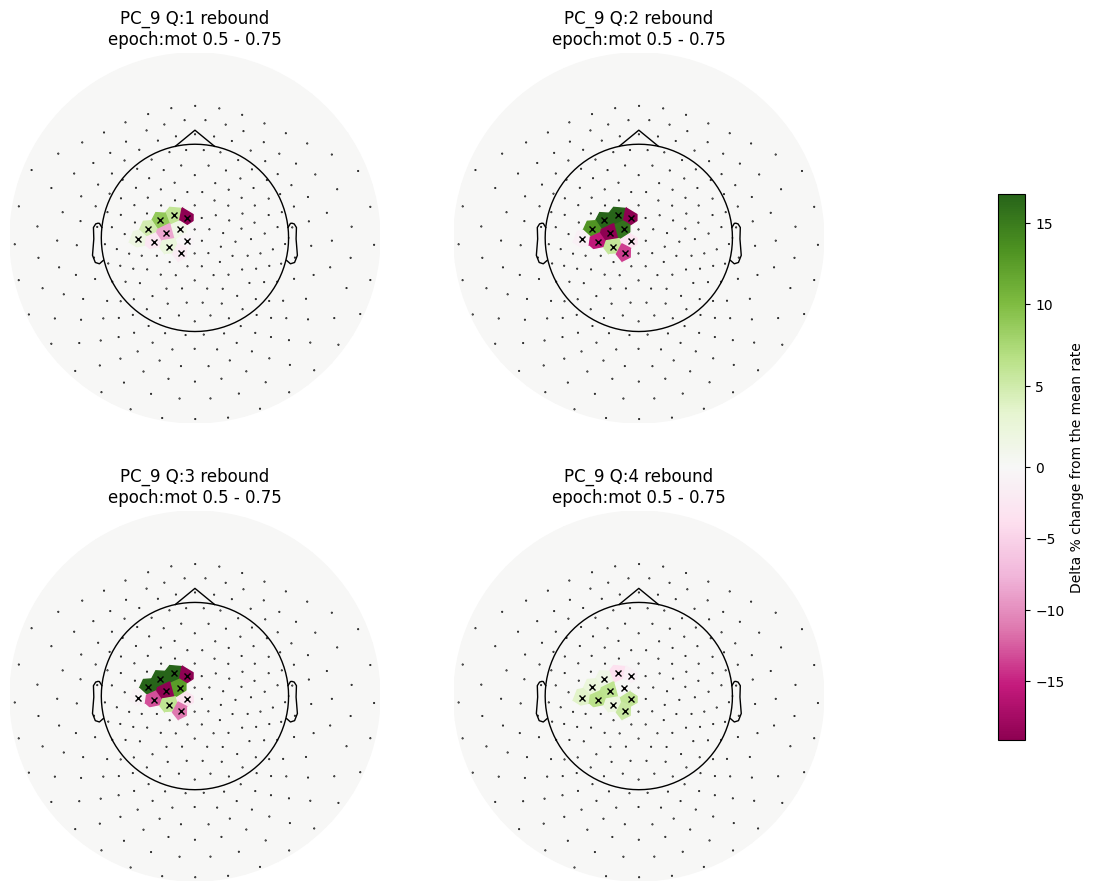

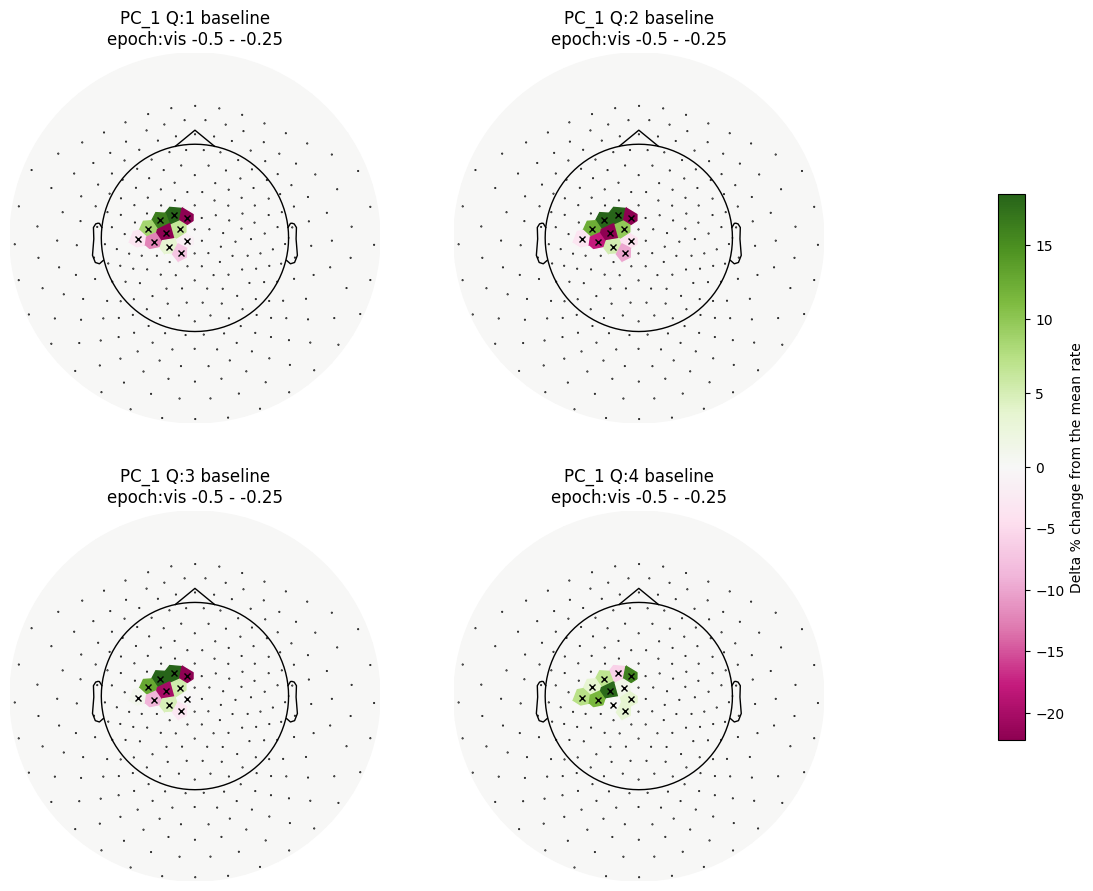

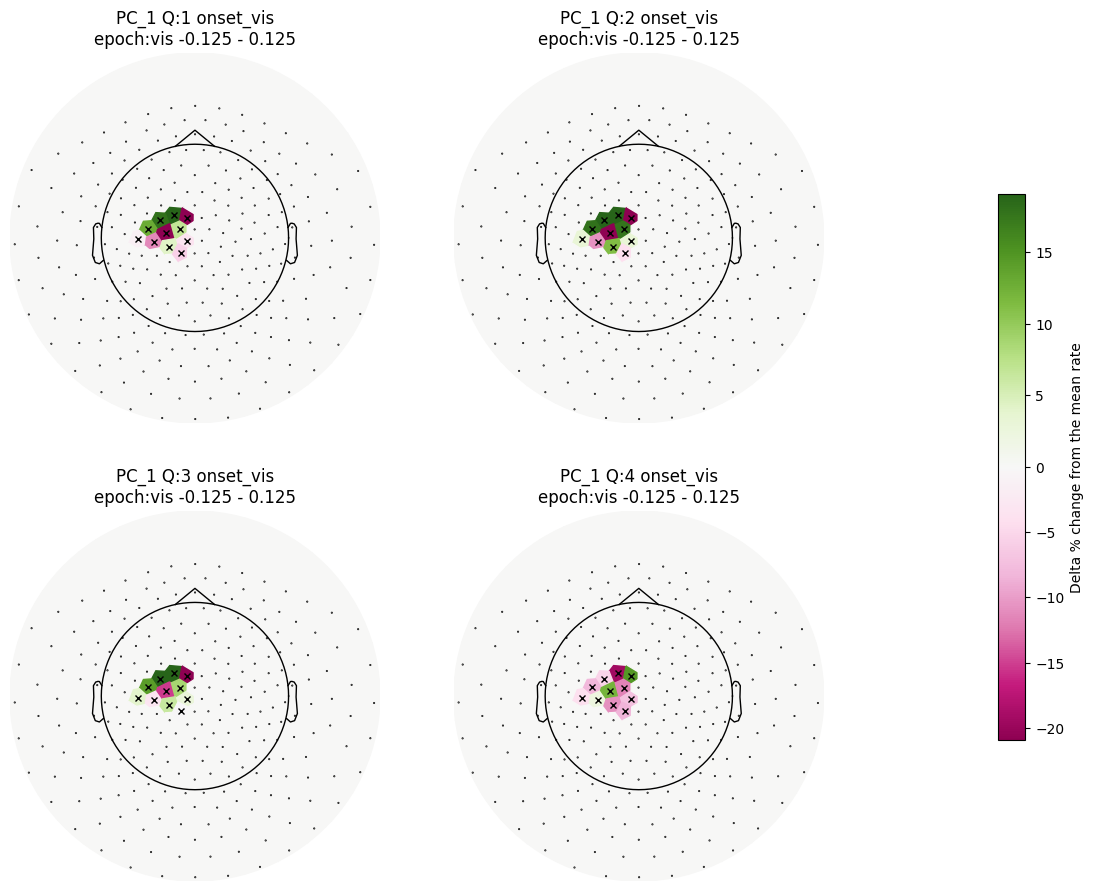

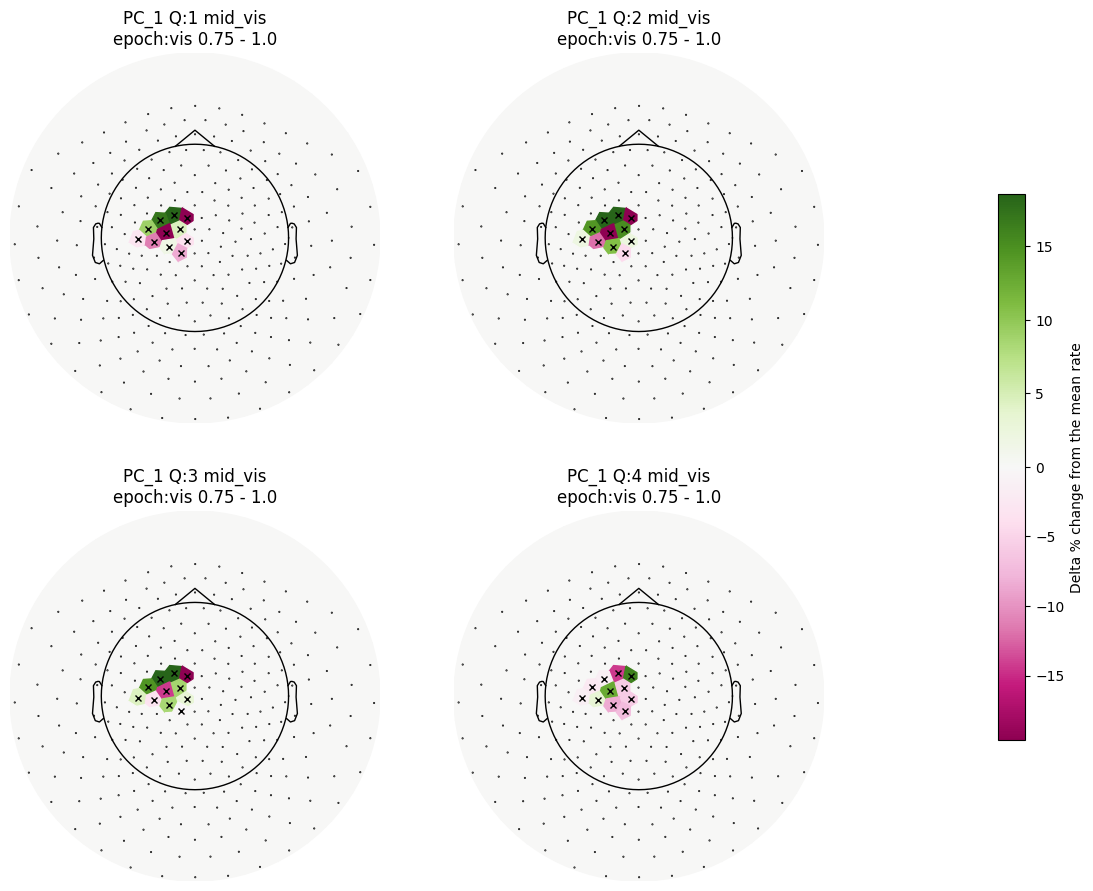

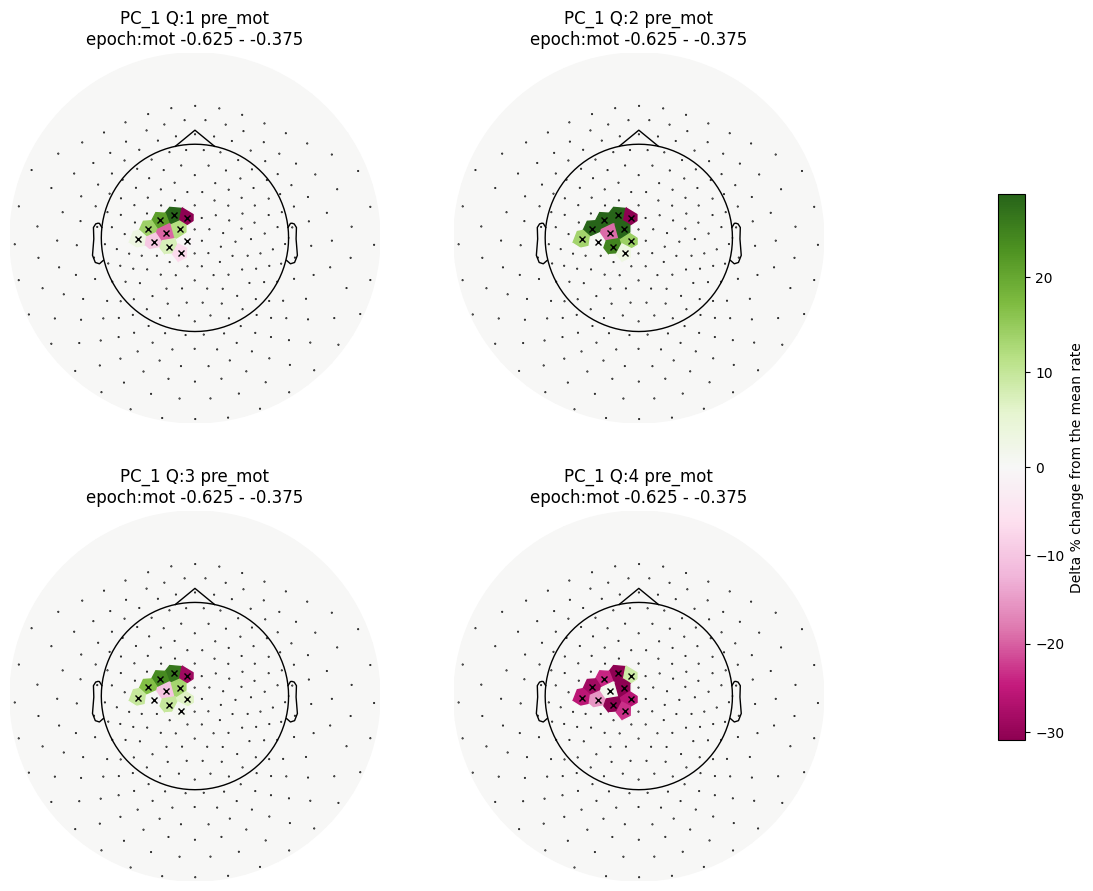

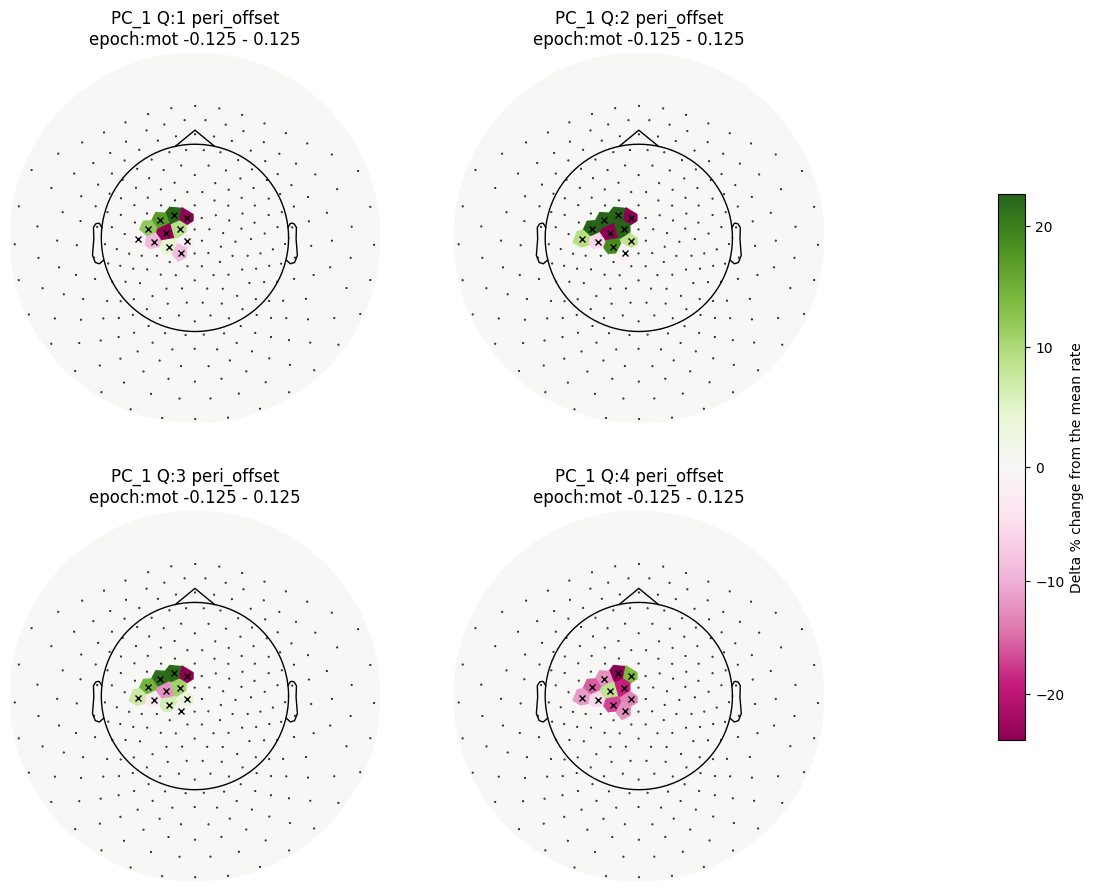

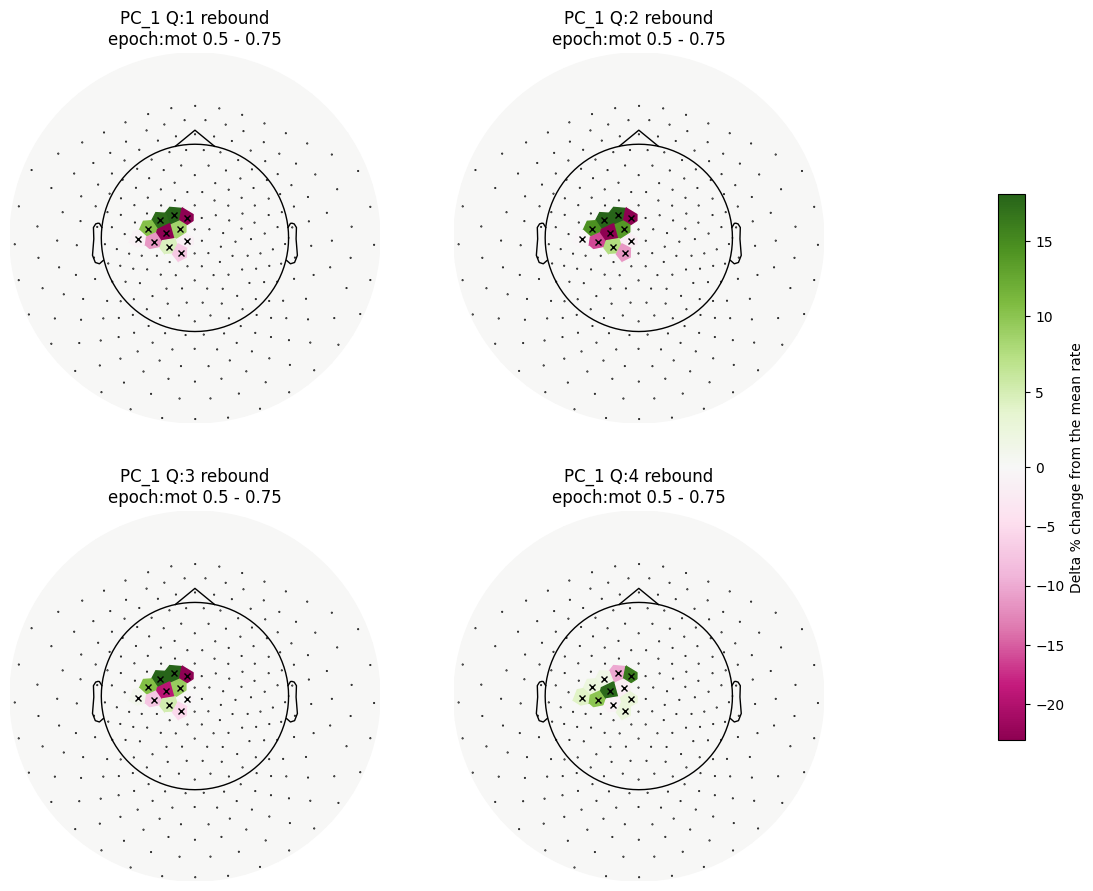

In [221]:
pc_r = "PC_7_range"
for pc_r in pc_ranges_columns:
    for time_label in times.keys():
        inp_data = PRC_RES[(pc_r, time_label)]
        min_range = np.percentile(inp_data.burst_count,10)
        max_range = np.percentile(inp_data.burst_count,90)

        divnorm = colors.TwoSlopeNorm(
            vmin=min_range, 
            vcenter=0, 
            vmax=max_range
        )
        mask_params = dict(
            marker="x",
            markerfacecolor="w",
            markeredgecolor="black",
            linewidth=0, 
            markersize=5
        )

        label_perc = [
            "00-25 %",
            "25-50 %",
            "50-75 %",
            "75-100 %"
        ]


        f, ax = plt.subplots(2,2, figsize=(15, 10), facecolor="white")
        pos = list(it.product(range(2), range(2)))

        for r in range(4):
            subj_ft = inp_data.loc[inp_data.PC_range == r]
            mean_ch = np.zeros(len(visual_info.ch_names))
            all_ch = np.array(visual_info.ch_names)
            for ch in channels_used:
                ch_map = all_ch == ch
                mean_ch[ch_map] = subj_ft.loc[subj_ft.sensor == ch].burst_count.values[0]

            delta = viz.plot_topomap(
                mean_ch,
                visual_info,
                cmap="PiYG",
                cnorm=divnorm,
                mask=channel_map,
                mask_params=mask_params,
                axes=ax[pos[r]],
                extrapolate="head",
                image_interp="nearest",
                contours=0,
                show=False
            )
            ax[pos[r]].set_title("{} Q:{} {}\nepoch:{} {} - {}".format(
                pc_r[:4], r+1, time_label, *times[time_label]
            ))
        plt.colorbar(
            delta[0], ax=ax, pad=0.15, shrink=0.65,
            label="Delta % change from the mean rate",
            spacing="proportional"
        );
        path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_sensor/"
        filename = "sensor_map_{}_{}.svg".format(
            pc_r[:4], time_label
        )
        plt.savefig(op.join(path, filename))

In [208]:
ax[pos]

array([[[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]],

       [[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]],

       [[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]],

       [[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]]], dtype=object)

In [226]:
pd.concat([PRC_RES[(pc_r, tl)] for tl in times.keys()]).reset_index()

index sensor time_label  PC_range  burst_count
0        0  MLC21   baseline         0    23.794348
1        1  MLC21   baseline         1    34.600617
2        2  MLC21   baseline         2    21.691324
3        3  MLC21   baseline         3    -6.003436
4        4  MLC22   baseline         0    16.315926
..     ...    ...        ...       ...          ...
259     39  MLC61    rebound         3     2.828262
260     40  MLC62    rebound         0    -7.190437
261     41  MLC62    rebound         1   -11.405711
262     42  MLC62    rebound         2    -5.306744
263     43  MLC62    rebound         3     2.479045

[264 rows x 5 columns]

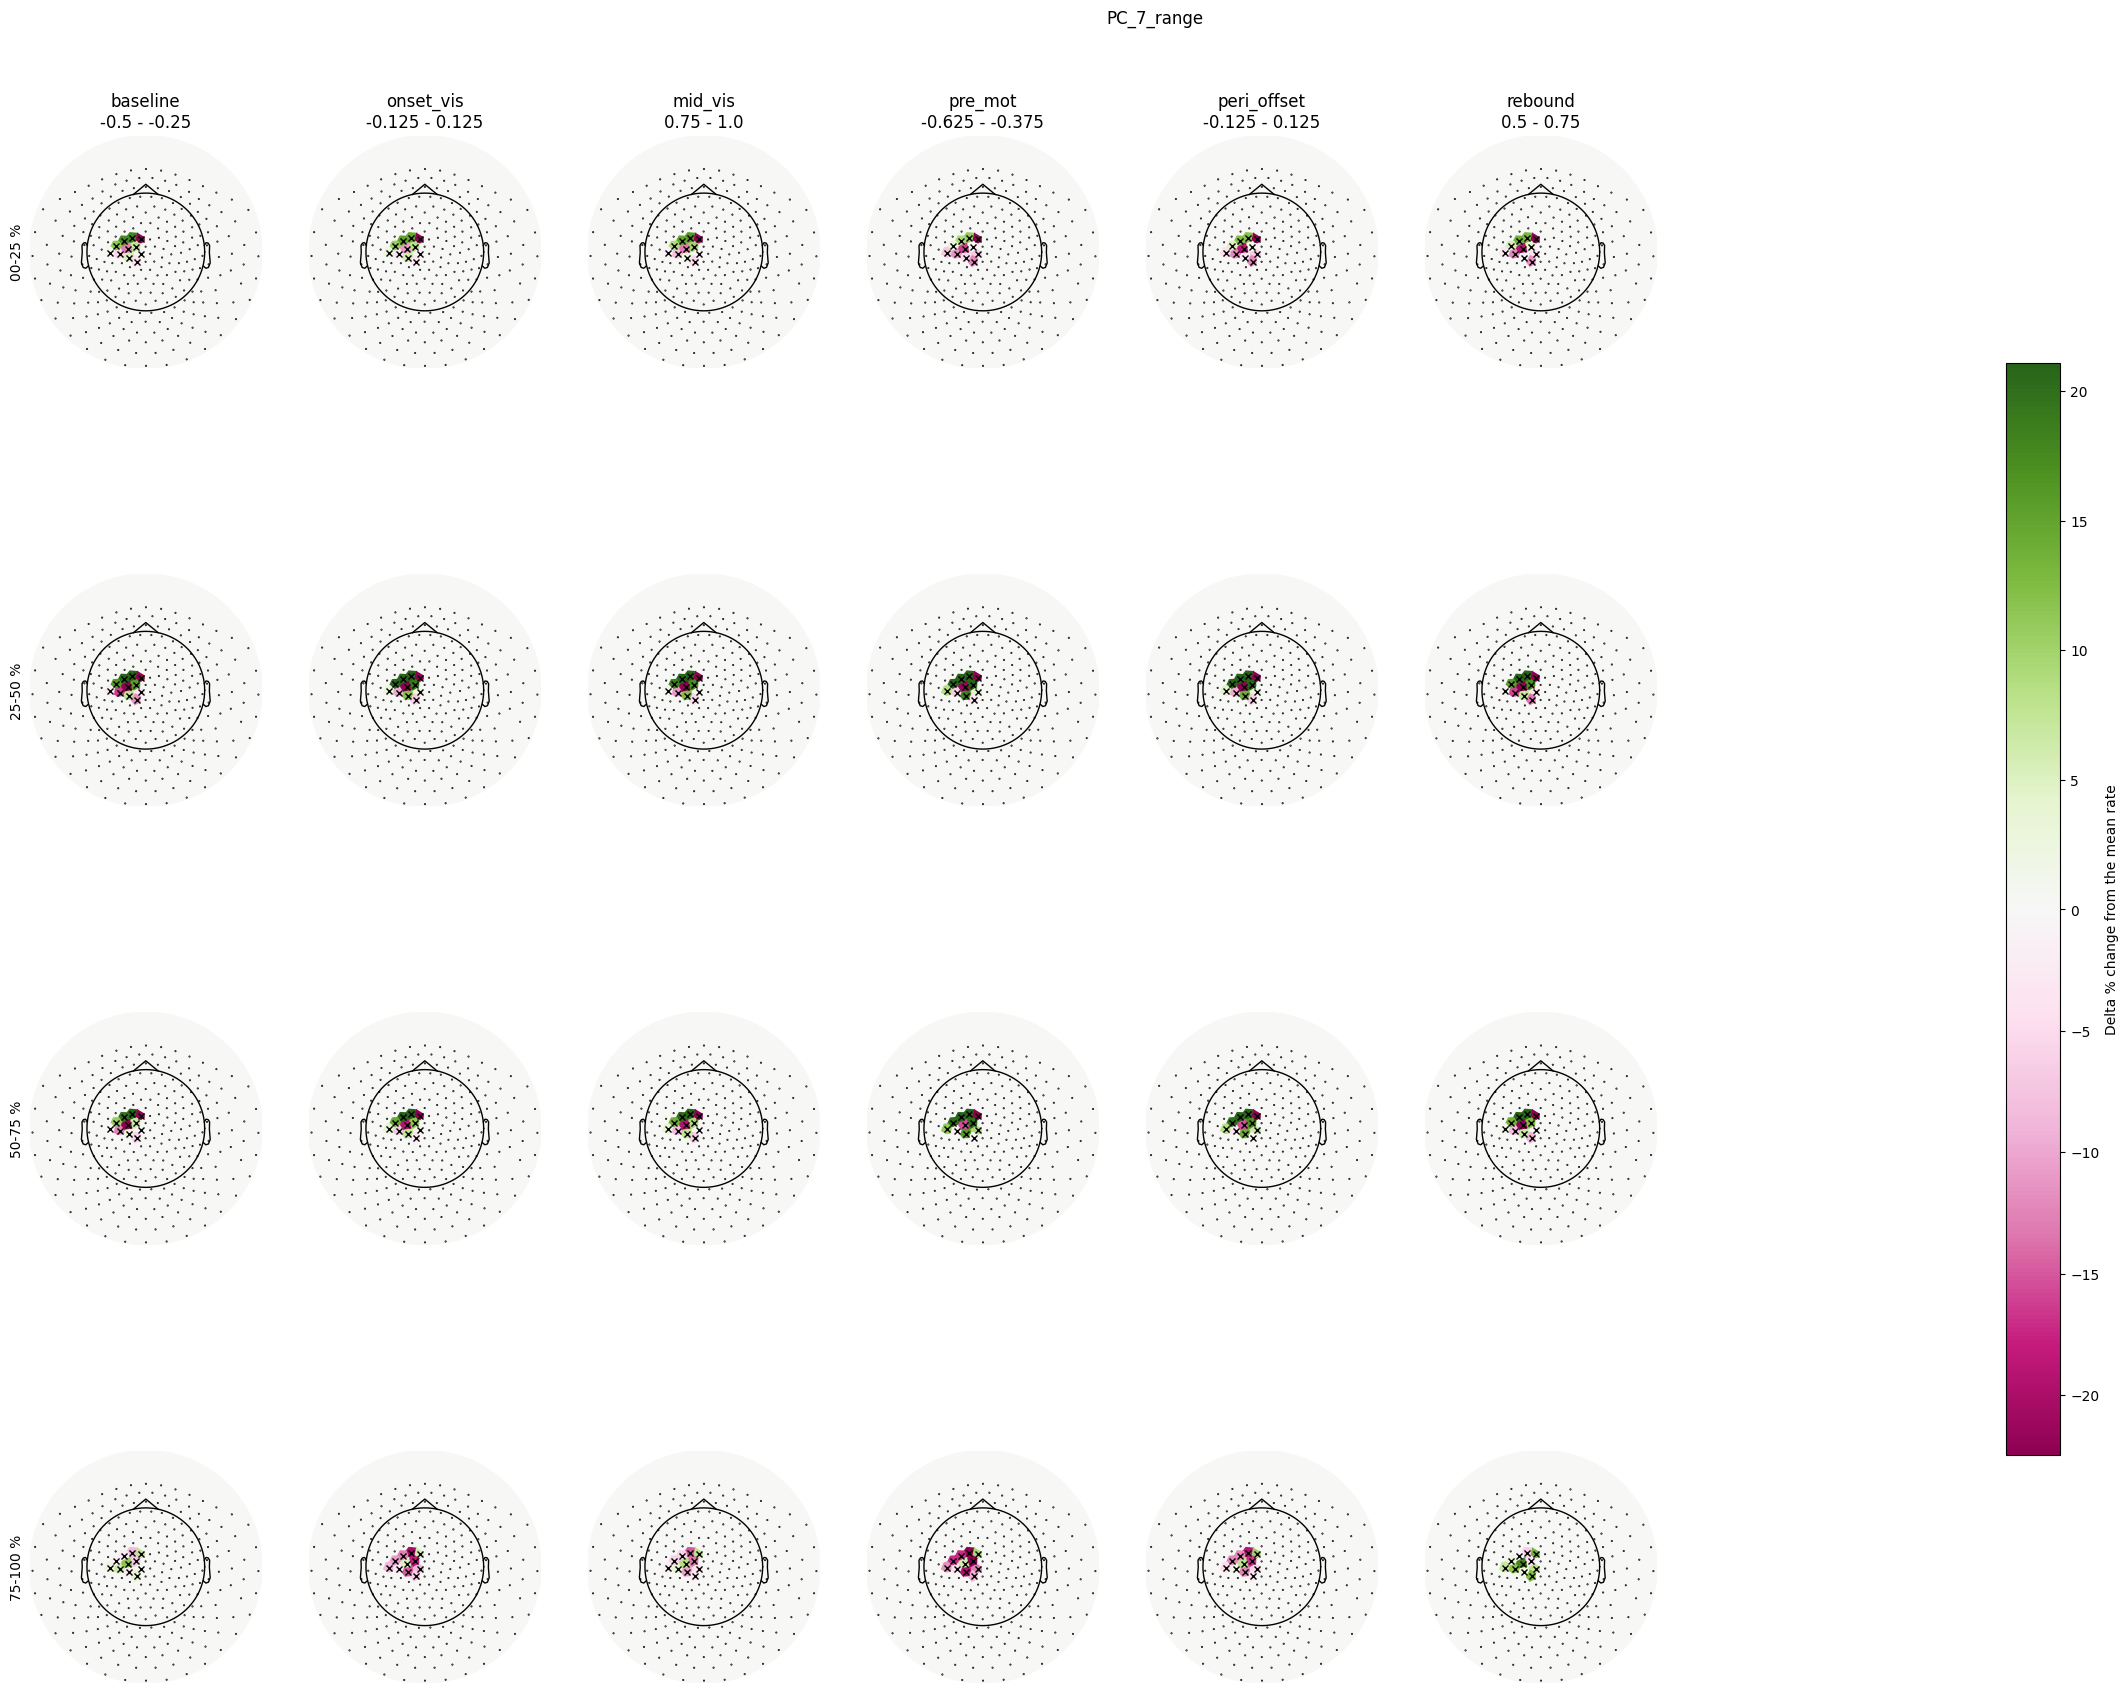

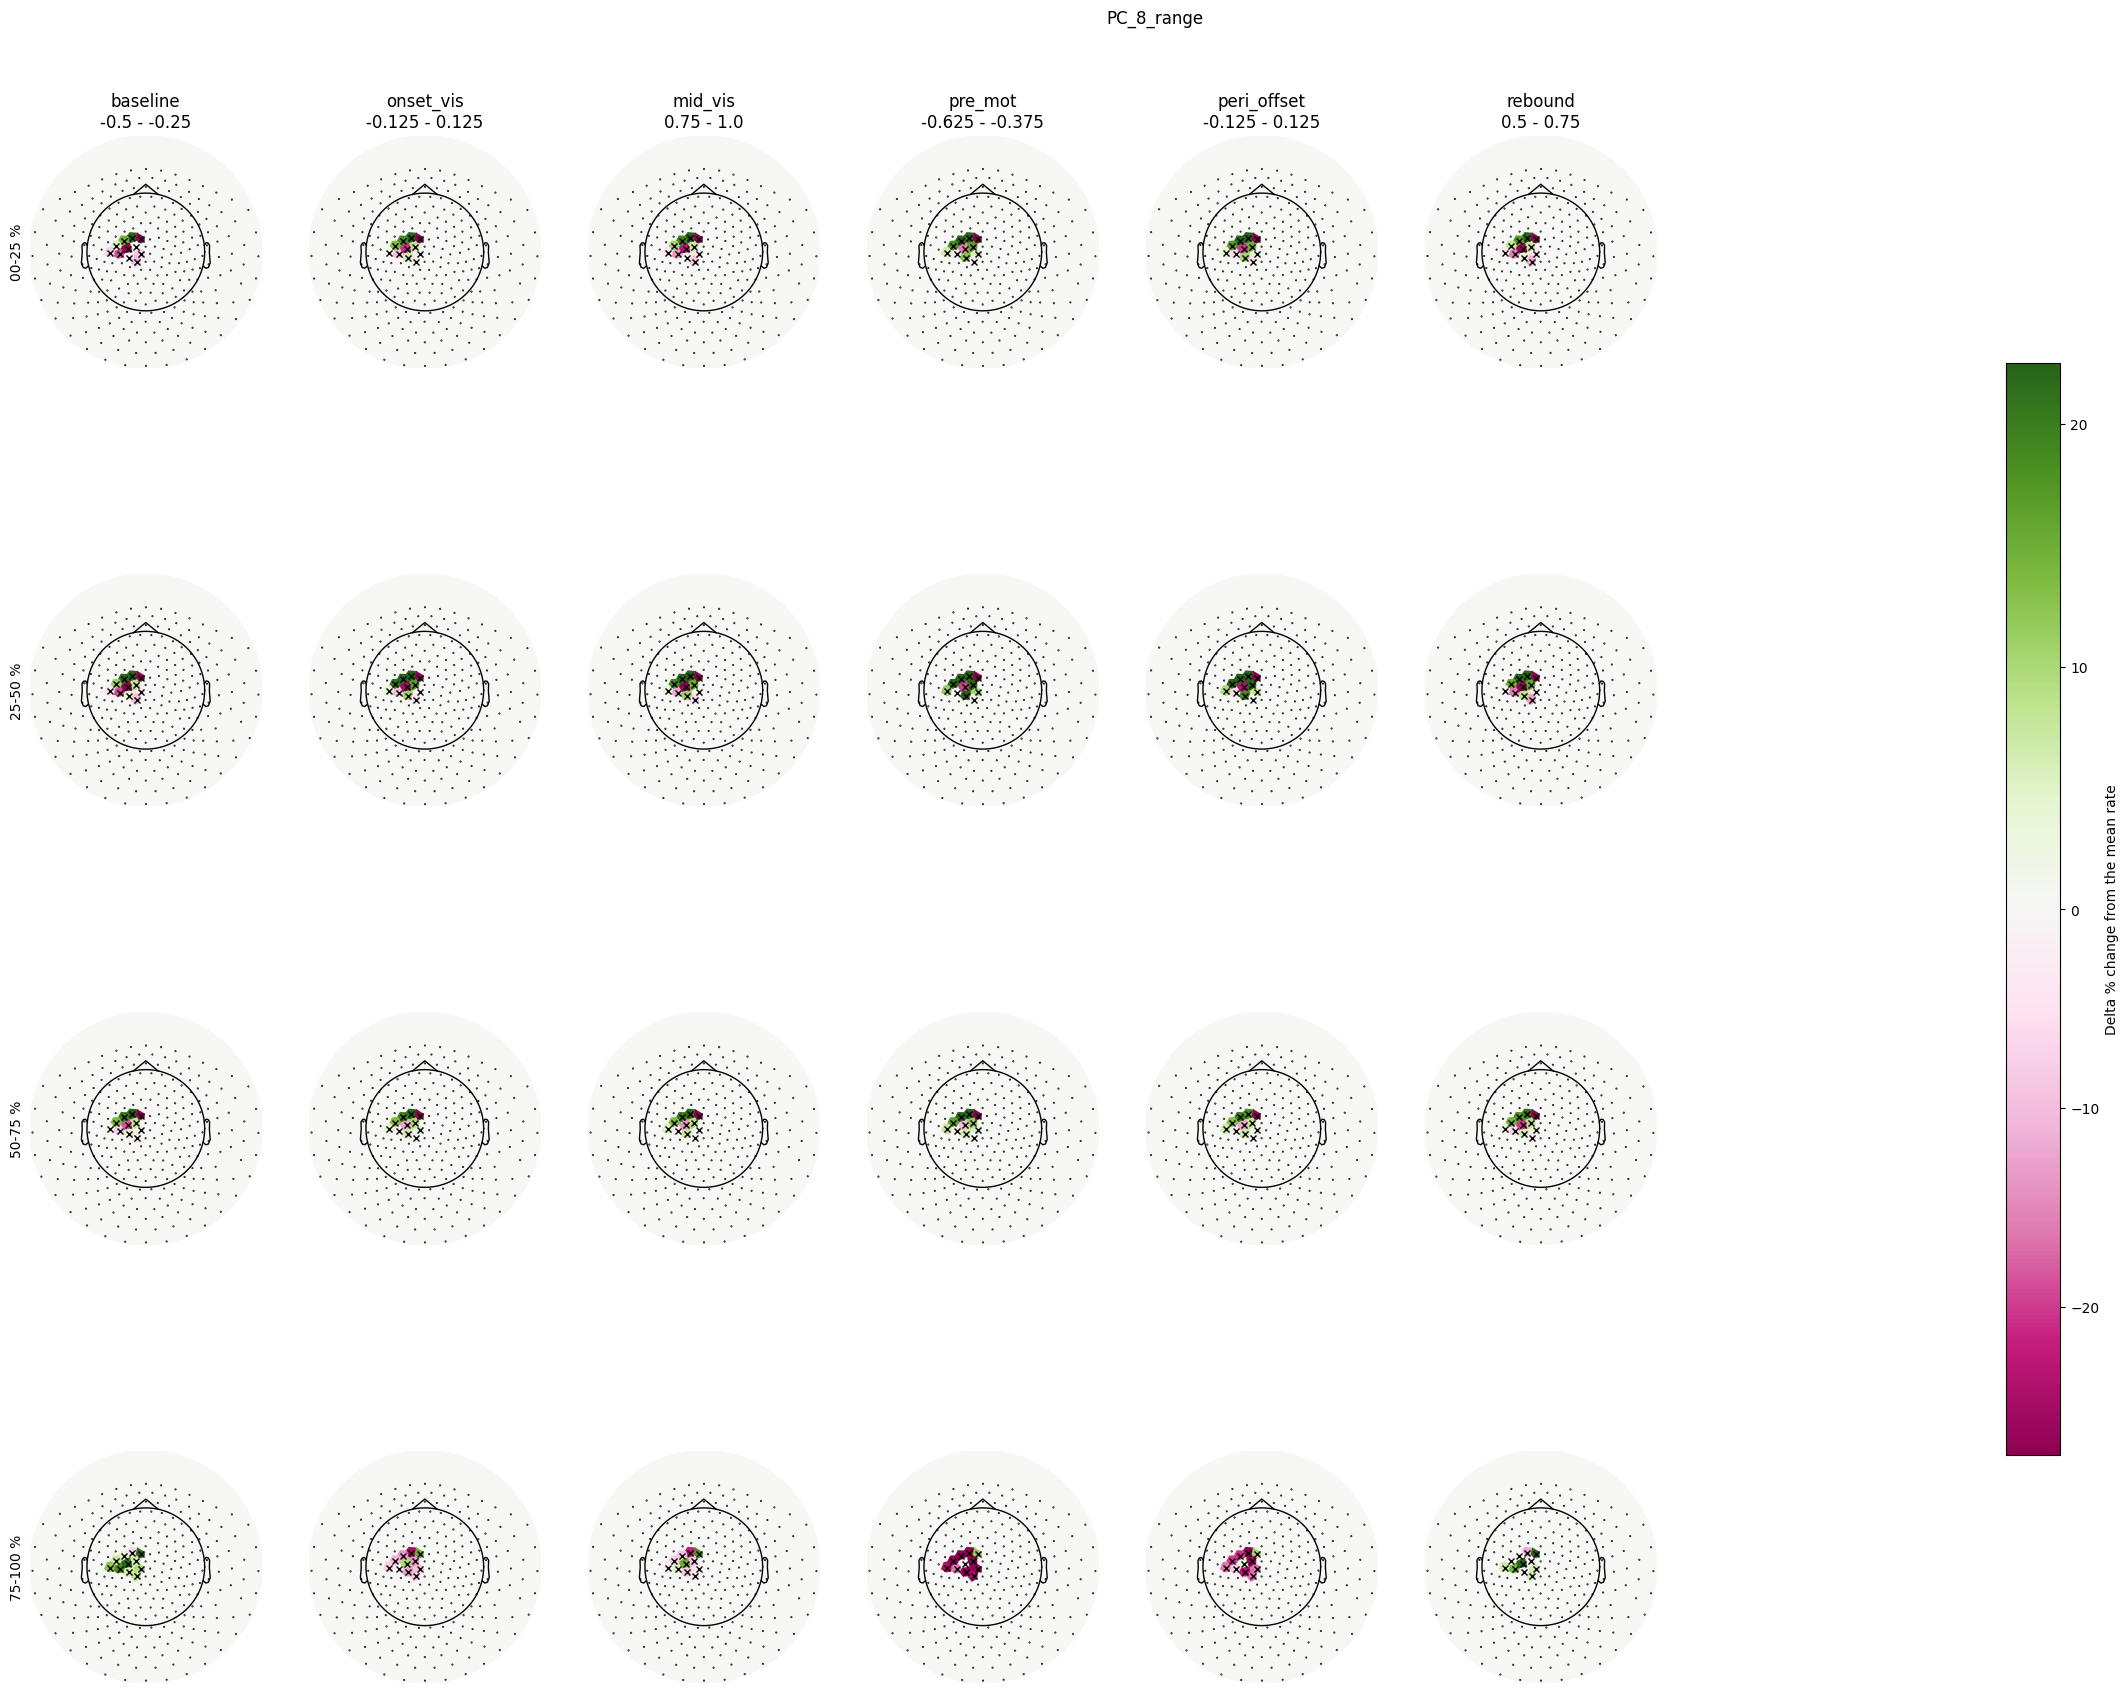

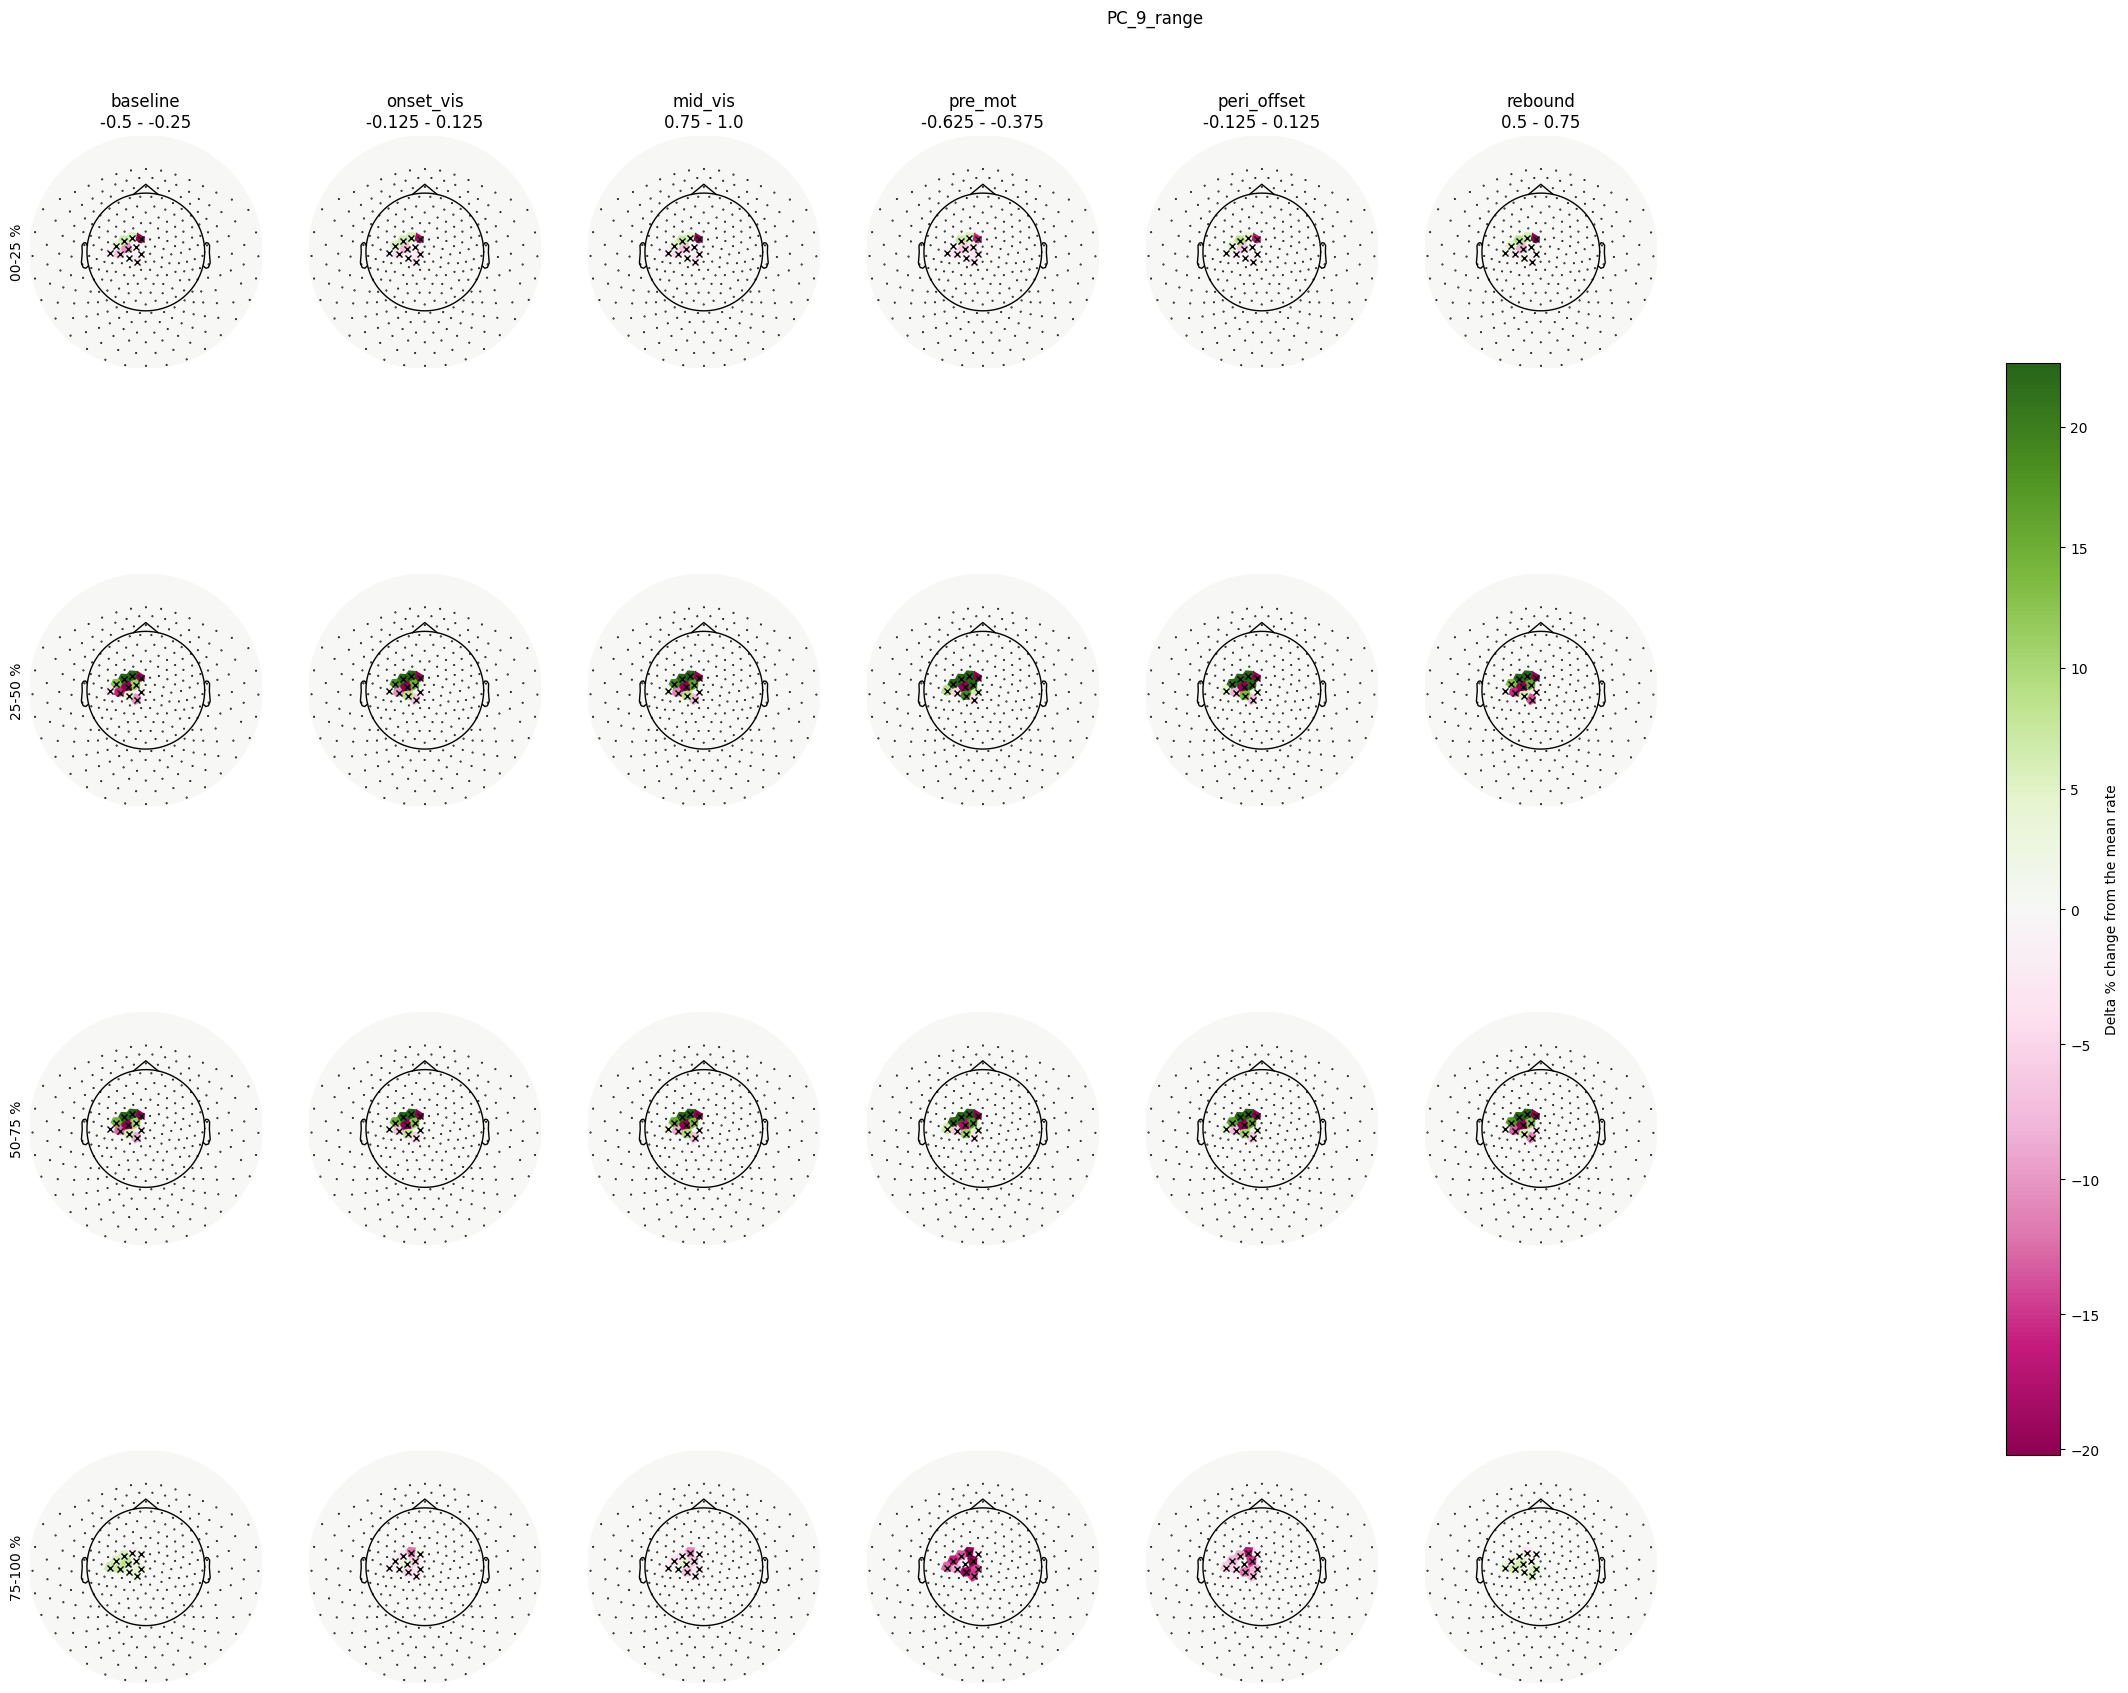

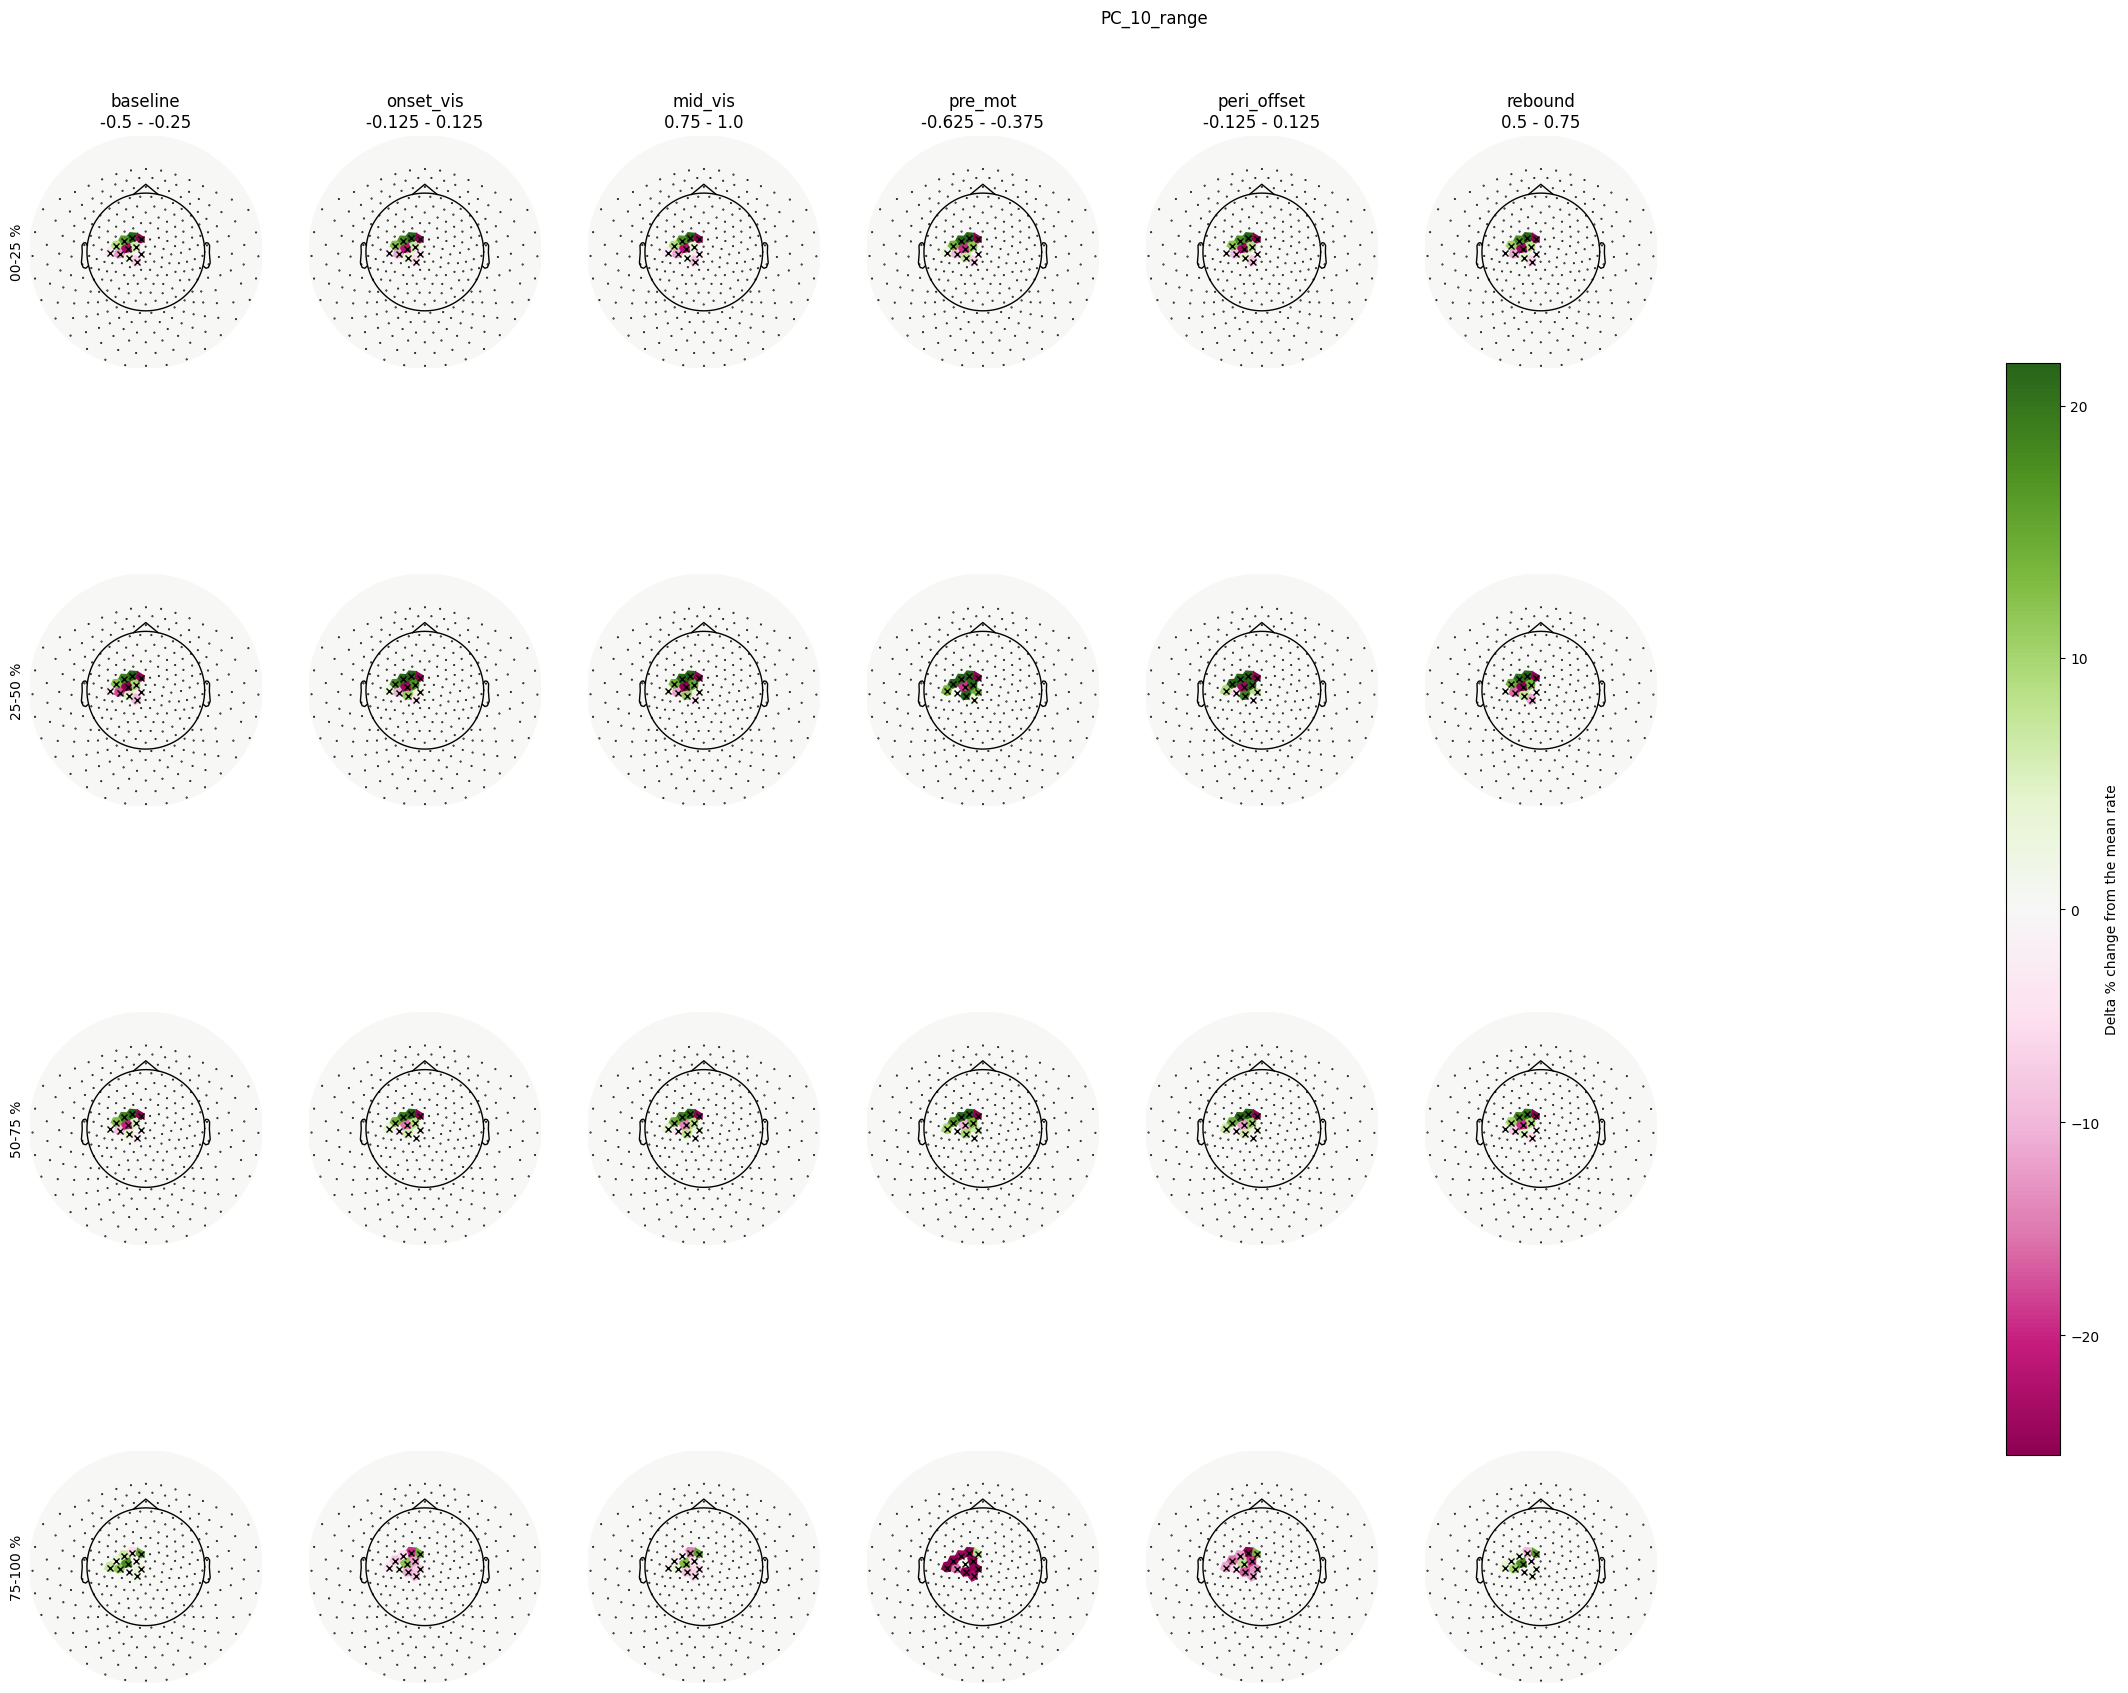

In [240]:
label_perc = [
    "00-25 %",
    "25-50 %",
    "50-75 %",
    "75-100 %"
]

for pc_r in pc_ranges_columns:
    inp_data = pd.concat([PRC_RES[(pc_r, tl)] for tl in times.keys()]).reset_index()
    min_range = np.percentile(inp_data.burst_count,10)
    max_range = np.percentile(inp_data.burst_count,90)
    divnorm = colors.TwoSlopeNorm(
        vmin=min_range, 
        vcenter=0, 
        vmax=max_range
    )
    mask_params = dict(
        marker="x",
        markerfacecolor="w",
        markeredgecolor="black",
        linewidth=0, 
        markersize=5
    )
    
    f, ax = plt.subplots(4, 6, figsize=(30, 20), facecolor="white")
    
    for row in range(4): #quartiles
        ax[row, 0].set_ylabel(label_perc[row])
        for column, time_label in enumerate(times.keys()):
            ax[0, column].set_title("{}\n{} - {}".format(time_label, *times[time_label][1:]))
            subj_ft = inp_data.loc[
                (inp_data.PC_range == row) &
                (inp_data.time_label == time_label)
            ]
            mean_ch = np.zeros(len(visual_info.ch_names))
            all_ch = np.array(visual_info.ch_names)
            for ch in channels_used:
                ch_map = all_ch == ch
                mean_ch[ch_map] = subj_ft.loc[subj_ft.sensor == ch].burst_count.values[0]
            
            delta = viz.plot_topomap(
                mean_ch,
                visual_info,
                cmap="PiYG",
                cnorm=divnorm,
                mask=channel_map,
                mask_params=mask_params,
                axes=ax[row, column],
                extrapolate="head",
                image_interp="nearest",
                contours=0,
                show=False
            )
            
    plt.colorbar(
        delta[0], ax=ax, pad=0.15, shrink=0.65,
        label="Delta % change from the mean rate",
        spacing="proportional"
    );
            
    f.suptitle(pc_r)
    path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_sensor/"
    filename = "all_map_{}.pdf".format(
        pc_r[:4], time_label
    )
    plt.savefig(op.join(path, filename), dpi=120, format="pdf")